In [1]:
## 3D Vision course implementation, most of it is being reused from the train.py file
## Author: Dusan

import torch
import torch.optim as optim
from tensorboardX import SummaryWriter
import numpy as np
import os
import argparse
import time
import matplotlib; matplotlib.use('Agg')
from im2mesh import config, data
from im2mesh.checkpoints import CheckpointIO
import torch.nn as nn


AttributeError: module 'im2mesh.encoder.point_plane_net' has no attribute 'PointPlaneResnet'

In [ ]:
## mimicking for Shape3D and config.get_dataset() function 
## most of the setup has been copied from occupancy_networks/configs/default.yaml
## our config is in occupancy_networks/configs/point_plane_net.yaml
cfg = config.load_config('configs/point_plane_net.yaml')


In [5]:
# Shorthands
out_dir = cfg['training']['out_dir']
batch_size = cfg['training']['batch_size']
# backup_every = cfg['training']['backup_every']


In [6]:
# Dataset
train_dataset = config.get_dataset('train', cfg)
val_dataset = config.get_dataset('val', cfg)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, num_workers=4, shuffle=True,
    collate_fn=data.collate_remove_none,
    worker_init_fn=data.worker_init_fn)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=10, num_workers=4, shuffle=False,
    collate_fn=data.collate_remove_none,
    worker_init_fn=data.worker_init_fn)

In [7]:
L = 3

In [8]:
len(train_dataset)

30661

In [10]:
print(train_dataset[1000]['points'].shape)
print(train_dataset[1000]['points.occ'].shape)
print(train_dataset[1000]['inputs'].shape)
print(train_dataset[1000]['inputs.normals'].shape)

(1024, 3)
(1024,)
(256, 3)
(256, 3)


### Upscaling MLP from N x L to N x 1024

In [119]:
###TODO : move layers to sequential values
class MLP(nn.Module):
    """
    From Point-PlaneNet : Then 4 MLP layers (respectfully with 64, 128, 128, 1024 neurons) are used \n
    to transform per-point’s features to higher-dimensional space and a global \n
max pooling layer is used to extract global feature vector. \n
    All MLPs are followed by batch normalization and ReLU.
    """
    def __init__(self):
        
        super(MLP, self).__init__()
        self.mlp64 = nn.Linear(L, 64)
        self.batchnorm64 = nn.BatchNorm1d(64)
        
        self.mlp128_1 = nn.Linear(64, 128)
        self.batchnorm128_1 = nn.BatchNorm1d(128)
        
        self.mlp128_2 = nn.Linear(128, 128)
        self.batchnorm128_2 = nn.BatchNorm1d(128)
        
        self.mlp1024 = nn.Linear(128, 1024)
        self.batchnorm1024 = nn.BatchNorm1d(1024)

        self.relu = nn.ReLU()

        
        

    def forward(self, x):
        
        #for batch processing
        output = []
        
        if(len(input.shape) == 3):
            for i in range(input.shape[1]):
                output_part = self.forward_function(x[:,i,:])
                output.append(output_part)

        
        output = torch.stack(output)
        return output
        
        
    def forward_function(self, x):
        x = self.mlp64(x)
        x = self.batchnorm64(x)
        x = self.relu(x)
        
        x = self.mlp128_1(x)
        x = self.batchnorm128_1(x)
        x = self.relu(x)
        
        x = self.mlp128_2(x)
        x = self.batchnorm128_2(x)
        x = self.relu(x)
        
        x = self.mlp1024(x)
        
        
        return x

In [120]:
input.shape

torch.Size([32, 1000, 3])

In [121]:
input = torch.randn(2, 1000, L)

In [122]:
input[:,0,:].shape

torch.Size([2, 3])

In [123]:
model = MLP()

In [125]:
model(input)

tensor([[[-0.2495, -0.6288, -0.1383,  ..., -0.4559,  0.0190,  0.0033],
         [ 0.4888,  0.0360,  0.1603,  ...,  0.1058,  0.1282,  0.1080]],

        [[ 0.3752, -0.2680,  0.0714,  ..., -0.1822,  0.1697,  0.4804],
         [-0.1690, -0.3471, -0.0331,  ..., -0.1177,  0.0046, -0.3602]],

        [[ 0.3380, -0.3313,  0.1685,  ...,  0.0296,  0.2579,  0.1147],
         [-0.1194, -0.2132, -0.1084,  ..., -0.3587, -0.0776, -0.0513]],

        ...,

        [[-0.0258, -0.5830, -0.0036,  ..., -0.1762, -0.0902,  0.1349],
         [ 0.2066,  0.0382,  0.0301,  ..., -0.1784,  0.2569,  0.0120]],

        [[ 0.3394, -0.1044,  0.1229,  ..., -0.0599,  0.3518, -0.2444],
         [-0.1267, -0.4505, -0.0747,  ..., -0.3052, -0.2072,  0.3251]],

        [[-0.1365, -0.3972, -0.1311,  ..., -0.1934, -0.2110,  0.3071],
         [ 0.3138, -0.1520,  0.1185,  ..., -0.1108,  0.3566, -0.2345]]],
       grad_fn=<StackBackward>)

In [126]:
model(input).shape

torch.Size([1000, 2, 1024])

In [ ]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

### Visualization of models using matplotlib

In [4]:

from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
%matplotlib inline

#On in point_plane_net.yaml setup with data.pointcloud_n of 100000 and data.pointcloud_noise of 0.001
cloud = train_dataset[4000]['inputs']

fig = pyplot.figure()
ax = Axes3D(fig)
ax.scatter(cloud[:,0], cloud[:,1],cloud[:,2])
pyplot.show()

### Random sample from dataset manually chosen, just to compare model sizes

In [ ]:
niz = np.load('data/ShapeNet/02691156/10155655850468db78d106ce0a280f87/pointcloud.npz')

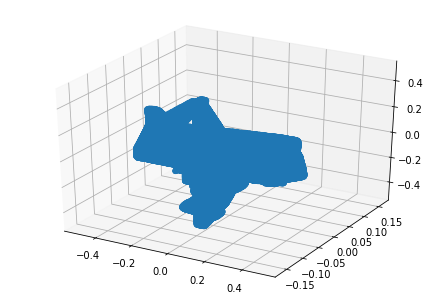

In [43]:
niz['points'].shape

fig = pdata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAb4AAAEuCAYAAADx63eqAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDMuMC4zLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvnQurowAAIABJREFUeJzsvXt4W3eZ7/vVXZal+G7Ht9hJbCdxEpo0ceOUQsttCmV2mM7QApsO155nzuwO04EZmBw6dGZ3txAup3uATgeYlmmgMKVlmKeZA3R2C7S0UJKmSdM2N99kW7ZlyZZt3aWldTl/hN/qWrKuay1Jy9Lv8zx5oLK81k+ytL7rfX/v+34NgiCAQqFQKJRawVjpBVAoFAqFUk6o8FEoFAqlpqDCR6FQKJSaggofhUKhUGoKKnwUCoVCqSmo8FEoFAqlpjDn+TntdaBQKBTKRsSQ7Qc04qNQKBRKTUGFj0KhUCg1BRU+CoVCodQUVPgoFAqFUlNQ4aNQKBRKTUGFj0KhUCg1BRU+CoVCodQUVPgoFAqFUlNQ4aNQKBRKTUGFj0KhUCg1BRU+CoVCodQUVPgoFAqFUlNQ4aNQKBRKTUGFj0KhUCg1BRU+CoVCodQUVPgoFAqFUlNQ4aNQKBRKTZHPgZ1C2dDwPA+WZZFIJGA2m2EymWAymWA0GmEwGGAwZDVpplAoVQoVPkpVQgSP4zjwPC/+ryAIMrEjQkgFkUKpHajwUaoKnueRSqXA8zwAwGAwwGg0iv+kCIIgimI6RAjNZrP4u1QQKZTqwCAIQq6f5/whhaIHBEGAIAjrBI+IFM/zYBhmnfDlO176d4OIKBVECmVDkPVLSYWPsmHJJ3gEEgWqFScqiBTKhoIKH6V6IClKlmVzCh5BK+HLtZ5sgkh+7nA4qCBSKOUl65eM7vFRNgxSwbt06RI2b96MhoaGiotINiETBAHhcBgejwc7d+6UPd9oNIpVplQQKZTyQoWPonsEQQDHcWJlpsFgyFihme8Y5RYVInAGgwEmk0m2Fp7nkUwm1z0/vcI0U1EOhUJRBxU+im4hgseyrChc5J/RaBTTnIWgp0gqU2RH0qTk9aY/P33/0GQy6eo1USgbCSp8FN2RSfDSox6DwbBuTy0bG0EgyBoLFURBEGQFNekpUwqFkh0qfBTdUIjgEYqN+CpJoQKdiUIFUZrKlUaIVBAplPVQ4aNUnGIEj1BMxFdJSiU2SgTRaDRCEASYTCbYbDYqiJSahQofpWIIgiCOFStU8AgbRfjKTT5B9Hq94DgO3d3d4s9IyjS9qIYKIqVaocJHKTtE8MieVTGCR9hIqU49IBVEInTAG4LIsixSqZTsd6ggUqoVKnyUskEEz+fzgWEYdHV1Kb6IbqSIT8/rzBchUkGkVCNU+CglJz3CY1kWyWRS1YVyowif3sSg0H5GKoiUaoYKH6VkEOcDaUpTSQ9eJmiqUxmkDUIphQgiwzCyn1NBpOgNKnwUzckmeAQtRItMb9kIbITIVC3pe4gE6SDxbIJIxrdRQaSUCyp8FM2Qmr8C2WdYahXxpafa9IjeLuLlHt2Wa46pIAhgGAZnz57F1VdfLf5MKoQ0QqSUAip8FNUUKngErSK+QiIpnuexsLCAxcVFOBwO1NfXi/+k8zMp5YV8RqQTaAC5IKaLdHq6lIxto4JIKRYqfBRFFOqFlwnSSK2GfMLH8zy8Xi9mZmbQ0tKC7du3I5lMIhqNYn5+HtFoFDzPw263w+l0imJI7IOqlUoM685F+npyRYgkhZ5LEIkoUkGk5IIKH6Uo1AgeQYv9uWxRI4nwZmZm0NbWhoMHD8JisYBhGNTX16O5uVn2WhKJBKLRKCKRCJaXlxGLxQAAdXV1MkGsq6tTfCGthT0+pRRabEMFkaIlVPgoBUEuMMvLyzCZTKivr1d8ESlFqjNd8EZGRmC1WsW1ZztGXV0d6urq0NraKjtWPB5HNBpFOBzG4uIi4vE4jEajLFXqdDphtVpzvgd6u8jqLeIjNlNKKUQQ06GCSKHCR8lJutv5ysoK7HY7XC6X4mNq2c6QS/DUHJuIW3t7u/g4x3GIxWKIRCJYXV3F3NwckskkTCaTLDp0Op2wWCyq1lAq9CZ8atsrsqFGENMrTPX0flG0gQofJSPpgkcuACaTSRc9eIIgIBQK4cUXX0R7e3tewdPi4mUymeByudaJPsuyYrp0aWkJbrcbLMvCYrHAbrcjkUggFArRgpoMqI34iqUQQYzFYnC73RgcHJSNeKOCWD1Q4aPIyGX+CmgbrSmB53nMz8/D7XbDbDbjmmuuqXh0ZTab0dDQgIaGBtnjDMNgdXUVwWAQCwsLiEaj4DgOdrtdFh2Ws6BGjxGfHtYj/YyTnkOTySQTRIZhZM+ngrhxocJHAVC4NZAW/XNKqjqJ4M3OzqK9vR27d++G1+utuOjlwmq1orGxEXV1ddi5cyeAK+9zMplEJBJBNBrFysoKYrEYBEFAXV2dKIZqC2o2CjzP666KVrqmQiLETIKYyQux2v+WGwkqfDVOsV54JpMJyWRS1TmLqeqUCl5HR4cY4YVCoaLEU0+Rhd1uh91uz1pQE4lEZAU1DodDtodos9lUVZjq4X0g6G09QGFinE8Q078jZJsgfWyb3kS/VqDCV6MoMX8FrkRrmQoDiqGQVCfP85ibm4PH45EJXjHH2EhIC2qkkD2naDSKtbU1WUGNNDqsr69XXdRTCUpV3KIGnucV78VmEsR0c+D052drzKeUDip8NYYa81dAu1aEbOQTPOkxNkJ/nNp15iuoiUajWF5exvT0NFKpFCwWyzpBNJvf+JrrLcIqd3FLIXAcp6kY5xvsnUsQpfuHVBC1gwpfjaCF+StQukhLKnibN2/OW7SiRFD0dtFXQ66CGiKIXq9XLKix2Wyor69HNBqFzWYDx3G6qDDV49+kXPuOxQpiIBAQb2gy7SFSCocKX5UjFbxTp07h0KFDqr4kJpNJdapTCsdxmJubw9zcHDZv3oxDhw7JIpRsFCPA0rmQlaCc57VarbBarWhqapKdn4xrC4VCWFpawuLiIniezzihppypR70Xt1SCbIK4srIi3rRItyjIc0mESAUxP1T4qpRMEZ4WaSWtIj5BEDAzM1O04BE2Uqqz0kgLalZWVtDa2oqmpiYIgiArqPH7/YjH4wCwrqDGbreX5LXoMeLTSzScDsdxYupTSnqEKH1PqRdiZqjwVRmZBE/LD7la4SMRXjQaBcuyRQseYaMIn54xGAxwOBxwOBxoa2sTH+d5XpxQQ3oQE4mEWFCTPrJNDXotbtHbmoDsgpwvZcqy7LoWpFoXRCp8VUI+81etUDq5heM4eDwezM/Po7OzE/X19di+fbvidVRbVWe5KCTCMhqNcDqdcDqdssdZlhUFMRAIYHZ2FgzDwGw2i9GhdA+qEPRY3LLRhC8bVBCzQ4Vvg1OsF57a1FKx7QzpgkcivMXFRcVrADZWxLdR1pkPs9mMTZs2YdOmTbLHU6mU2JC/uLiISCQiK6iRTqhJv3DrMeLjOE6XgxG0SsGqEcSTJ09i3759MpeTjQgVvg1KsYIHvBElqfnyFBppZRM8KWpEeKNEfHq7Uy7FnprFYkFTU9O6ghqGYURBJOltUlBDxDAej+uu/1CvEV+pbxIKEcRvfvObuO+++6jwUcoLz/OKvfBIRWYphU8qeF1dXVn38EjEpvQirDdBocgxGAyw2Wyw2WxoaWkRHyceiEQQA4EAUqkUvF4vHA6HLF1aqoKafOhV+CqFVBDD4bDsBmejQoVvA6CF+Sug3YDpTKk7juMwOzuLhYWFnIKXvhZ6gSkvla6ilHogtrW1wWg0wmq1or29XZxQEwqFxIIa6UQbIoj5PBDVonUDezURCoXQ2NhY6WWohgqfjiGCt7y8LE7uUFO0onUPHnAl/eHxeAoWPEK5U5W10seXj0oLXzrS6UGZCmo4jhMb8ldWVmQFNekTarTal1O7HVDNJJNJ2O32Si9DNVT4dEi6F9758+cxOjqq+i5US+FLF7zR0dGiLhYbZY9OLXoSGT2SL+o3mUxZC2qIIPp8PrE9xmq1rhPEYkVMj5kIPVS/6ukGTi1U+HREPvNXPQgfy7JIJpM4efIkuru7ixY8Qq0In97Qa8RXLBaLBY2NjbK0GymoIYI4Pz8vFtTY7XaZGObyQNSj8OmpqV5Pnx+lUOHTAfnMX4lgKWn0lqJGbFiWxezsLLxeLwAoFjxCMdZElOpFSyGWFtRIqw5JQQ2ZULO8vIxYLAYAGUe26UlkCCzLqv7+q4VhGF22eSiBCl8FKdQaSKsUpZLjSAWPRHgnT55UfWFQYka7EdFbv6HeIr5yRFfSgppsHojhcFj0QIzH45iYmIDL5ZJNqKnk+6YHMQ4Gg+tSzhsVKnwVQIn5a7mFL5PgSb94WjTClyvi43lebJh3Op1lH8RMyU4lhVhaMdre3i4+fvr0aXR3dyMej2N1dVXmgSiNDp1OZ9kiID0IX7VUdAJU+MqKUvNXrYSvkKkrLMtiZmYGi4uL6OnpyZjSLGcjvBp4nofX68X09DRaWlpgMBiwtLSEeDwuzqkklYRazJ3cCNRixFcsgiCgoaFh3UWeeCBGIhEsLS3B7XaDZVlYLBbZyDaHw6F5WlIvwpdug7VRocJXBtSav5rN5nVGlUrINWeTCJ7X60Vvb2/OPbxyNMKrQRAELC4uwu12o6WlBSMjI+vcKYizefrcyfSLmJKqwEzroWRGb0JMyLSmXB6IpCF/YWFB9EC02+3rRrYpFXk9CN/a2hoVPkp+1AoeQctUZzKZlD2WHuEdPnw47xdMq0Z4reyNyEVKEAT4/X5MTU2hsbERBw4cgM1mA3DlwiE9XzZnc+lFTFoVSIogiBjW1dUVdMHW20Vdb0Kjx4ivWKxWK5qbm9cV1CSTSfGztLKyglgsBkEQZCPbCv0s6aG4hUZ8lJyQD73f70dbW5tiwSOUYo8vlUphdnYWi4uLeSO8dLQQLS2KPqTHWF5exuTkJFwuF/bv37+uybbQc2W7iMXjcUQiEVkRBNkjkqZL9V71pjfh09t6tELqgZitoCYSicg+S+kj22w2myxDUemILxgMUuGjrEfqhceyLNxuNzo6OlQfV8s9vlQqhYmJCfh8PvT29uLw4cNFi7JSa6L0tWhxjOXlZbjdbjgcDrzpTW+Cw+FQdcxMSH3rpEUQZKpI+p6P1WqVpUtpqjM71Sp82ZAW1EghqfdoNIq1tTVZQU19fT0YhoHT6QTDMBXbiw4Gg+jq6qrIubWGCp8GZDJ/tVgsmu1hmUymdTYhxZJKpbC4uAi/34/BwUFFgkco1poo2zHUvD+rq6sIh8NYWFjAnj171l1IMqH1RTbTVJF0VwKPx4NYLIaXXnppXbq0EkOY9SY01ZDq1IJsqXdSUDM9PY1IJILz588jlUrBYrGsm1BT6lRoKBTCzp07S3qOckGFTwXlMn81m82Ix+OKfjeVSmFmZgY+nw9tbW1ob2/Hli1bVK2nknt8wWAQ4+Pj4p3w8PCwrqoxM7kSRKNRHDhwQEyXpruaS6NDp9NZ8b2ccqJHIdYTpKDG4XCgtbVVdEaQTqjxer1iQQ3xQCSfqUweiEoJhUJV4cwAUOFTRLkEj6Ak1ZlKpTA9PQ2/348tW7bg8OHDiMVimJycVL2eSghfKBTCxMQEBEHA0NAQNm3ahJdffll3F6psSFNc0vQ3y7JidOjz+TA5OSlewKTRoZqKQCl6FBo9RXx6HVCdXtxitVphtVrXeSAmk0nZUO9YLCYrzpJOqCn2fafFLTWKEvNXLShG+DIJHvmAa1VJqdUeXyHp20gkgomJCbAsi4GBAVlvld6moijBbDZnnDlJKgLTR2xJy+OVTBTR2/tFhbgwCilukRbUpHsgSgtq/H6/mEEivazkc5Ur/R4MBmnEV0soFTzSO1aO4dIMw2BmZiaj4BVznELQYo8vn2hFo1FMTk4ikUhgYGAgo+NztQ66zlURSO7mV1dX4fF4RIseaXTodDpzXiT1JDRU+ApDTVWntDirra1NfJznebGXVZp+l1YrE/9Dp9OpOOJ76qmncOedd4LjONx+++04evRoxuf9+Mc/xi233IKXXnoJBw8eVPRaC4UKXxa0MH8lQlNK4ZMKXl9fX86iFS2Fr1Spzng8jsnJSUSjUWzfvl2cuJKJYiI+PV1clWI0GjMWQKRSKTE69Hq9iEQiYnpLGh3W1dXpTmj0th49tA1kohTryuaByLKsbLjD8ePH8dOf/hSJRAJ///d/jze96U3Ys2cP9u7du+6zmGndd9xxB55++mn09PRgZGQER44cwfDwsOx54XAY3/jGN3Do0CFNX2M2qPCloZXbOfDGxBW1vV2ZJrcwDIPp6WksLS3lFTyCFpEaOY7WwpdIJDA1NYVgMIjt27eL/Y+5qIZUpxZYLBY0NTWt2++Rprd8Pp84gPny5cvYtGmTbABzJdGT8FVjxFcsZrNZVq1877334t5778W1116LW265BefPn8ejjz6Kt7zlLfjQhz6U81inTp3CwMAAtm3bBgD44Ac/iCeffHKd8H3hC1/A5z73OXzta18rzYtKgwrf7yFeeH6/H5s2bYLRaFS9h6flqDEiWEoEj6DVF1rLPr5kMgm3242VlRVs27YNu3btKvg9r9ZUpxZkS2+RAcyxWAyBQAAzMzNieby0EV/LasCNhF6FD6jsDYIgCDAajXjrW9+K66+/vuDfm5+fR29vr/jfPT09OHnypOw5Z8+ehcfjwR/+4R9S4SsX6eavbrcbw8PDqKurU31sk8mkmfClUimMjY0pEjytKbQwJRc8zyMQCCAQCKC/vx87duwo+otNI77iMRgMcLlc6wYwk97DSCQi9h7yPC+bJuJ0OivSe1hO9JrqrDTke1bs3z7T91N6DJ7n8elPfxqPPPKIqvUVS80KXza3c4vFoolYAVciPrWpRYZh4Ha7EYvFUF9fj4GBgYrfkao1tJ2ensbCwgLsdjsOHjyoqpGeRnzFkW1PLduoNjJNJBwOw+v1ir2H0uKHjTCqrVD0HPFVEnL9KZaenh54PB7xv+fm5mTTX8LhMF5//XXccMMNAIDFxUUcOXIEJ06cKGmBS80JXz63c63Sk2qPRQQvEAigr68P9fX16O7u1mRdalEiOFJ/v97eXuzduxfz8/OqLjI04istBoMho19dNnseafO0WjeCSqFH4dPDZ1ypM8PIyAjGx8fhdrvR3d2Nxx57DD/84Q/Fnzc0NGB5eVn87xtuuAFf+9rXaFWnVhTqhael8ClJdSaTSUxPT4uCNzg4CKPRiJmZGU3WpAXFVIdyHAePx4O5uTmZv184HNZk0DWN+IpDiyrKTPY80lFtpBqQ9B5Ke8WcTqds+LLe0KIKW2v0IMZKWxnMZjMeeOAB3HjjjeA4Dp/4xCewe/du3H333Th48CCOHDlSgtUWsK6KnLWMFGv+qnXEV6hASIs8+vv7RcHTGi16CwuJ+Hiex9zcHDweDzo7OzE6OiqbPKFVZage7oY3EqV6vzKNagPW94rNz88jmUzCbDaLw5eDwWBZZk0Wgh4nt3AcV/H3Ro0zw0033YSbbrpJ9tg999yT8bnPPvusonMUS+U/aSWEDI4uxgvPbDarLtyQHivd/y6ddMHLVuShZTN8KYWP53ksLCxgZmYGHR0dOHToUMYvbbmtjfQaYVSCcr4X2XrFUqkUotEolpeXZbMm7Xa7LDpUMlpLDTzPV1xk0mFZtuJiXE2WRECVCx+hWLfzRCKhyXlzpToLFTzpsbRshlfz5c7UziAIArxeL6anp9Ha2oprrrkmZ8GDnsxsKeXHYrGgoaEBVqtVnPgvCAISiYQ4u3RpaQmxWEzca5S2W5Sq95DjuIr3Naajh0pTKnwbCCV9eBaLBZFIRJPzZ0p1JpNJTE1NYXV1tagyfiJYaqvntLIUIscQBAE+nw9TU1Nobm7GwYMHC7pwaJGmpMUtxaOnyDd9v9FgMKCurg51dXWy3kPiVUf2DmdnZ8EwjNh7KK0wVSsQek11VnpNoVBoXQvMRqaqhU8JparqTCQScLvdWF1dxdatW7Fz586ix59p3QyvFCJ8fr8fk5OTaGhowNVXX73O9TwXWhSmUOHb2BSacs/mVSf1PZyfn0c0GpU5ERAxrKurK/i7podCknT0InyDg4MVXYOWVLXwqRkzpgUmkwnJZBIXL15ULHjSdWkxbkzt1BVBELC6uoq1tTXY7Xbs27dPUbM/TXVS1FaYZus9JL6H4XAYi4uLiMfjssHL5F+m7AkVvswEg0Ea8VUzWgkfmT25traGnp4exYJH0IOzwsrKCiYmJmCz2eBwOLBnzx7F69AiWqMRX/Ho6f0iY7C0RDqqTdp7yHFcxt5D4jxARFEPhSTppHvxVYJq8uIDqlz4lAiNxWJRVdUpHbbc19eHUCiEzs5OxccjaCV8So6ztraG8fFxWCwWDA8Po76+Hi+++KKqdWix12QwGAp6LYIgYH5+Hmtra7I7fr1d4GoNMjGpHJhMJtngZUDeexiNRuHxeLC8vIxQKCT7nOTzqSs1emlnoBFfFaNUYKSCt3XrVnHY8vT0dEXXpeY4wWAQExMTMBgM2LlzZ14LknKTr0BGEARxH7KlpQVtbW2IxWLrrHucTidcLpfum6u1QE+vrdKWRJl6D1977TXRSSDdp85kMsmiQ6fTWRZB4jgONput5OfJBS1uqXKK/SJmEzyt0bK4Jd++WDgcxsTEBHiex8DAgG5THLlSnYFAAOPj43C5XLj66qthtVqRSqUyzqLM1FydMtnxnTMRvOZPIM5e+aIMddTjLYNN+LNre6tmNmUl0eN+Gs/zsFgssFqtqK+vR0dHh/gzlmXF6NDn82FyclIUJWl0qPWoNr3s8VWL+zpQ5cJXyrvJeDwOt9tdcsEjaFXckmuPLxqNYmJiAgzDYGBgQPcf9EzFLcFgEGNjY7Bardi7d684WDeT2EtnUZIL3OJaDO/6p9MA5C0tLIALvigu+KL49gtzAIAPXb0Zn3/PkPYvrEaodMSXiVy9smazGY2NjbLIRxAEJJNJcVTb8vKyOKqNfLakvYdKXq8eUp3JZFITxxq9UNXCBygvgMj2pYzH45iamkIoFCrYP06LL7jJZALDMKqOQY6TvocZi8UwOTmJWCyGgYEB2cgpPSP920YiEYyPj4PneezYsUO2l0MgfwdBEPAvL0zh4d/MI/b7e4AmG7Cae8jOOv7tzCL8S37ccbhDdsevtyhGit6KW/QmfMVGoQaDAXa7HXa7Ha2trbLjkGzC6uoqPB4PGIaB2WyWfVYK2WuudMENMefW299KDVUvfEogkYT0w5YueMPDwwV9EDIdSwla7vGRyTSJRAKTk5MIh8PYvn07WltbN9SH22AwgGEYvP7664hGoxgcHJSlMtOfazAY8Py4H59+4hKSadf/YkWP8AsPj7/5g0akmDg8Hg+i0SiANwYzO51O2nKRBT2mOrW6wOca1Uaiw/S9Zml0KO091EOqE9DX/rBaql74lER8pLLTZDIpFjwCaY/QQvi02OMzGo1gGAYXL17E2tqaotekBxiGwdzcHFZXV7Fnzx60tbXlfA3ff3EKX/ovN0ohQYuMBQe3vDFpJP1uP5FI4NSpU7BYLGIRTaVse/T0d9ZrFFHKNVksFjQ1Ncm2EUjvIWm38Pl8st5D4odoMpkqMk6t0hFnKah64VOC2WxGJBLBxMSEGA0pFQcifGqrsrQytV1YWMDKygp27dqlqrdQi6HZ5KakmDUQI1ufz4e2tjbYbDZZv1Y644tBfPS7LyGgMKIrBJtJ/h6k3+2vrq5iZGQEDMMgHA6vs+0p1xxKvaHHiK8SSHsP00e1RaNRrK2tYXV1FfPz80ilUuKoNukNVCmFKRQKZdw62MhQ4UsjFoshFAohHA5jaGgIu3fvVt14XulRY6lUCtPT0/D7/Whvb4fZbFbdW0hSuGqFr9A0MM/zmJ2dxfz8PHp7e3H48GGEQiHMz89nfH4ixeHDD53E64sxxesrBKsR2NVZWJuH1WpFS0vLOtsecqcfCAQwMzODVColNlaTVotyuxSUA71GfHqB9B6azWYMDQ2J75XU99Dj8SAWi4HneTgcDtlNlFa9h9U2oBqoAeEr9A8fi8UwNTWFSCQCp9OJnp4e2d2XUrQcNVbscViWxczMDBYXF7FlyxYcPnwY0WgUbrdb9Xq0HDmWS/hI8/nMzAw2b94ssznKlMZOpjjc+7MLePyMT9XaCoXhAbNR+cXFaDSum0MpbawOh8NYXl5GPB7P6FJQbFuFnopbaMRXONLrWLZRbbFYTEyLer1esfdQOsRbyWem2prXgRoQvnxIBW/btm3YvXs3pqamNBErQLsRaMW6ns/OzmJhYQE9PT04fPiweIHRar6l2pmf+daS3nw+MjKyLgUo/X3vWhR/9+RFvDC1pmpNSnjh0iKu27lZs+NlM3XNNnZL2kdGUl8bIZLSW8Snp5uCYpG25khT/yzLZv3MSG+icu0301TnBiTbF4uU8EejUWzfvl2W0tTSjFarVGchAsrzPDweD+bm5tDV1YXR0dF10VQpZ35yHIffTK5g3B+G02KGyWzAZqcV2zo2wWUzwVWXXbikBAIBTExMwOl05nR9MBgMYDkOd/3kVfz4nF/1a1LKn//7GF79fEfJL+LZxm5J+8iIhx0pjJAW01S6FywdvUV8ehNiLTCbzWhoaJClKqUZhfT9ZlKNTETUZrOpmtP51FNP4c477wTHcbj99ttx9OhR2c/vv/9+PPTQQzCbzWhra8N3v/td9PX1KX/BBaKvb0IZSBe8TCX8Foslr3N6oWiV6sxVncrzPObn5zE7O7suHZiOlsJHROv0dAB/9aNzWIoVFgG+faABd/+33euELxgMijNB9+zZIzafZ+N7v5vF158PKH8RGnLwS8/j5c+/teznzdZHRqLDcDgsmzJCJg1lKpsvN3oTGr0JMVCaKDRbRkFajRwMBvHaa6/hM5/5DGw2G5qamvCd73wHe/fuxZ49ewoaX8hxHO644w48/fTT6OnpwcjICI4cOYLh4WHxOfv378fp06fhcDjwz//8z/jc5z6HH/3oR5q/5nRqRvii0SimpqYQi8Wwbdunw4pIAAAgAElEQVS2nD1rZrNZ7MdSi9ls1kREM61VEAQsLCxgenoa7e3teV3PAe2F78xMAB/+17NF/e4vJ4L45f/+LQDgtquBT79jQGw+HxoayptWefr8Av7i8QuK114KGAF46PlJ3P6W7ZVeCoDs0eGpU6fgcrlkZfPSfSCXy4X6+vqyRId6Ez699MtJKeea0quRt2/fjrNnz+L+++9HNBoFy7I4fvw4AoEAnnjiibzHO3XqFAYGBsTZpx/84Afx5JNPyoTvbW97m/j/R0dH8eijj2r8qjJT9cKXTCZx/vx5xOPxvIJH0NqMVisRJQiCgMXFRbjd7qz7X9nQysqH7PH95b+dU3WcR88s49Ezy/jpx4cw0L8l53Mn/GHc9R+v45UFbd9Prfj6r+fxp6NbYNPpHE/SxN/W1iYr3JLuAy0uLiISiYDjOJmhq5ZVggS9RVh6Ww+gn3FlIyMjuOWWW4r6PVKBTejp6cHJkyezPv/hhx/Ge97zHsXrLIaqFz4A6OrqQktLS8FfWq3NaLUqlBEEAT6fD1NTU2hsbMSBAweK7g/U6sJF9viW4tq0hL/3X8fwu8+2ocm5fh7g5FIE/9cjpzEf0eZvUkpGvvIiXr2r/ClPNWTbB5IaukqrBKViqMbeSW8Rnx6FTw/N40qdGTLdYGf7ez/66KM4ffo0nnvuuaLPo4SqF766urqiPzhaR3xqjyUIgjj8dnl5Gfv3789a8FEuSuF+PvrV3+CFv3kz2lxXxG/cH8KDv5rEzy7oYx+vEAQAp6aWcM029a0wWlNMpJ/N0JU4FKSP3JKOaCvU3qmcfnyFkGtAdaXQQ/pVaTtDT08PPB6P+N+k6C6dZ555Bvfddx+ee+65stkvVb3wKUFPVZ2kwpE0p+7YsaPiqQ+gNMIHANd97Tf4+s0DeG4qhJ9UsFJTDZ/8t4s4e7QZZp3tFwHqI/5sDgWkhyzd3ind0FV6ES+FA7satJipqzV6ED6lEd/IyAjGx8fhdrvR3d2Nxx57DD/84Q9lzzl79iz+7M/+DE899VTOCUxaU/krqA7ROuJTkupcXV3FxMQErFarWOF4+vRpXeT8AW36+LJx539MlOS45WT/sd/gNZ2lPEuVWszWQyYdyDw/P49oNApBEMS9w0gkAqvVqpuUpx5TnRtZ+MxmMx544AHceOON4DgOn/jEJ7B7927cfffdOHjwII4cOYLPfvaziEQi4v7hli1bcOLECa1fwvq1lfwMFUbJF0rLD3+xIkpK+k0m0zrXc633C9VcbMgeX88mM+ZC+t97qwRf+a9L+NyNOyu9jIqRaSAzz/OIx+PiRJr5+XnMzc2tmz9ZCXsnPaY6WZat+I2umj6+m266CTfddJPssXvuuUf8/88884yqtSml6oUP0K6SUQmFilU4HMb4+DgEQcha0q+lNZHayJEI33v2bMa//HZO9Zqqke+f9uMz7xys9DJE9BBZkcb6+vp6RCIRcfRW+vzJTPZOLperpAO8aaozMyzLFj3mTO/UhPBVknwXGuICkUqlMDg4mDOlUIrmczXHSKVS+ODBbip8OXjzV36DB95ZPc7VWiJNLWaaP5nNzLVU9k56TXVW0q1jI49xy0VNCJ+SiE8L251cxGIxTExMIJFIYGBgIKuBqpRKzP3MdwyXsTq/GFoR44Fz3jhGKr0Q6CPik5JvPdnMXEtl76RX4au0+zqgLx9HLagJ4VMCMaPVurw2Ho9jcnISkUgEAwMDRfUXap3qVAPLsvD5fAgENk6rQaX4+mvAx99b+ZSV3lAqNKWyd6p0dJWJSgtfIpFAXV31ZSyo8GVBKwNZ4MrdUiwWw/T0NILB4Lqh2IWiB+FjGAZTU1NYWlpCfX099u/fD/zsF6rXVO1cfew3OFfhKs+NFvEVgxb2TnqN+CpZ3BIMBqvOmQGoEeFT45yulmQyiWQyibNnz2L79u3YtWuX4i97Jff4pN5+W7duRUdHB7xer64upHqGB/C937nxkdGtFVuD3vZrSi3Exdo7cRwHl8sFQRB0Y+9U6cktSlsZ9E5NCJ8S1AofwzCYnp7G8vIyrFYr9u3bB4fDoWpNJpNJk8b6YgRUanUk9fYLhUKatVZUip99Ygg3fXesbOf76i88uPmqLrjqyjOdIhOVvpBLqVSElW2A96VLl2C32xGPx2X2Tukj2soZgVU61Ukjvg2M0ohPiciwLIvp6Wn4fD709fVhdHQUr732mibN3mazGfF4XPVxChE+qfNDJqujUk1uKRffu20PejubAZRP+ADg2vtPVqyxvZpTnWoxGAwwGo1obm6W9axls3ey2+0yMSyVvZMehE9pD5+eqQnhU0KxER/LspidnYXX60Vvb6/M9VxP1ZjkOPmcz6emptDc3JzV+WEjC98PP7oHe3vyV9GWiq8/cxl3vnNHxc6vF/S2p5ZpPdmiw0QiIfYdSu2d0pvw1UaHehA+muqsIUhVZz44joPH48H8/Dy6u7szup7rTfgyuacDb8wFJUUruQZhl3JkWSnpqgd+9voyLvhieNfO1vy/UAIeOunDX75jqOzRjp4iLEB/6yl0covBYEBdXR3q6upKbu9U6XmmNOLbwChNdeZKK/I8j7m5OXg8HnR2duZ1PdeT8KUfh4xJM5vNBTmfA2+I528nN9Yg6YUo8OjLiwCAe5+aqtg69n/xebxS5pSn3opb9BjxqYmulNo7EfNfPba7hEIhbN1auYKsUlETwqeEbFEaz/NYWFjAzMwMOjo6cgqe9FiVbkNIP04qlUI0GsX4+DhYlsXg4GBRd3Yk1fnx772qej21CAfgzGvn0bu5HS6XqyAbHy3QU4Slt4ivFEJciL3TwsJCVnunSt+sqJnTqWdqQvi0aGcQBAFerxfT09NobW0tyvVcq1SnVgLKcRy8Xi/8fj8GBwcLmhqTjtFoRCTBqF5LLfPREwE8+aE6LCwsIJlMygY1u1wuzUZxESp9EU1Hb8JXziHVhdo7xWIxnDlzJqe9Uymh7Qw1BqnqlLqeNzc3K3I9N5vNSCaTqtekNmXKMAzcbjd8Ph+cTif279+v+MJjMBjwpd9S4VPL/3x2Gcc/cQ0AyAY1z8zMIBaLic3W0tmUagom9CQ0gL7WU+kh1en2TjzP48yZM9i7d29Oeyfy2bBarZq/n3SPr8Ywm82IxWL43e9+h4aGBlx99dWKXc8rPXFF2nze39+PtrY2LC4uqvqS8LyAOfVaXvOc8Saw975fyx6zGYD+ZjMa6+2IMjy2NjF4y5YI+uvDiMViYsEEueAR14J8f0+9RVh6RE/vD6nozGXvFIlEsLa2hrm5uXVZAy3snUKhkOy81UJNCF8xH2ZBEMTqxkQigWuvvVb1rDqtUp3FfilzNZ+rrch8x1fpmLJSkRSAywEWCEQAAK8vAv95Uf4chzmBN/clMdAQALgEttVzaG9wYtOmTbJUqZ4u5JTiyOXFJ7V36ujoEB9Pt3eKxWIQBEGxvRNtZ9jgFOLQsLKygomJCdjtduzduxfnzp3TZECrlo7uhVBI87maCJRlWSzEtFgpRSkxFnh6MoanZY9Gfv/vDbrtgN0G9DfZcfOeZjQZNva0nVpCSQ+f1vZOsVisoCrvjUbNCF8u1tbWMD4+DovFguHh4XU2KGrR0jk9F4IgYGlpCRMTEzmbz9Wu59CXnlWxSko5mU8ASACTwQR+Mb1w5cH/lKdW+zYBf7BrM+rsFly3tRFb212wmU00WqwwWjWvK7F3unjxIiwWC4xGo6JU6VNPPYU777wTHMfh9ttvx9GjR2U/TyaT+MhHPoKXX34ZLS0t+NGPfoT+/n7Fr7FYakb4MkV8oVAI4+PjMBgM2LFjR8lm0pUj4ltZWcH4+Djq6+vz7keqET6WZREpX/BKKQMzIeBfTl7pbfzGc551P3dagL1d9fjYoR4c6GuCTWfWPdVKqae25LJ3unDhAn7+859jYWEB+/fvR2dnJ6666ircfvvtGBgYyLvuO+64A08//TR6enowMjKCI0eOYHh4WHzOww8/jKamJkxMTOCxxx7D3/7t3+JHP/pRyV5rOjUjfFLC4TAmJibAcVzO/jWtzGi1FL70NYVCIYyNjRXdfK50j2/3/3pW0e9RNi6RFPDiTBQvzlzO+hy7Cdjaascf7GzFH+/rQrNTWSFYpdBbqwdQmXFlxN7p/e9/P26++Wa87W1vw5kzZ+D1enHu3LmCCvxOnTqFgYEBbNu2DQDwwQ9+EE8++aRM+J588kn8wz/8AwDg/e9/P/7iL/6irMVXNSV80WgUExMTYBgGAwMDeauViGCpNac0Go2afbFItBaPxxU3nyuN+OIJWsZJyUyCAy76Erjom8PXn5tb9/PWOgPevqMVn7x2C7qa9LdnpLcpMkDu4pZyEA6H4XK5YDAY0NXVha6uroJ+b35+Hr29veJ/9/T04OTJk1mfQybeBAIBtLaWZ4xgzQjf9PQ0vF6v6HpeCFoJn9ZcuHABiUSiqNciReld1b4vPa/o9yiU5biAx19ZwuOvLMke33/+Zfzjn+xCs0udZZda9Ch8ehhQraSHL9NNfvo1p5DnlJKaEb6enh709vYW9eaWuxozF6T5PBQKYXBwEFu2bCnrB8WzHCrbuSi1w9n5KK7/xmnZY/UWYHeHE3/33gFsbS2PF5xehc9isVTs/Eq9+Hp6euDxvLFXPDc3ty5aJM/p6ekBy7IIBoOKJkgpRV9/6RKiZKqB1sKnJN3JsiwmJyfx0ksvwel0oqOjA42NjWWvuHvnN0+V9XyU2iWaAk7NRXDk269g732/xt77fo3HTs2W9JyVjq4yUek1KY34RkZGMD4+DrfbDYZh8Nhjj+HIkSOy5xw5cgTHjx8HAPz4xz/G29/+9rJe02pG+JSgpfAVW1DC8zxmZmZw8uRJmM1mHD58GN3d3ZrN6yyG83OBsp6PQknnvqensf++X4PlSmOFpdeIr9LCp6R53Ww244EHHsCNN96IXbt24dZbb8Xu3btx991348SJEwCAT37ykwgEAhgYGMD999+PY8eOab383Gss69k2GIV68hUCEdF8H2QyDNvtdmdsPteyJ7DQKqo//pezmpyPQlEDC2D0yy/g9Oe1t3PSo/BVurhFjTPDTTfdhJtuukn22D333CP+f7vdjieeeELV+tRQM8KnhUODGvIJFmk+n5ycRFNTU8mazwmkrzHf+3JxfkX1uSgUrUgKwD89+Wu8bbBVNnVE7V5YpaOrTFR6TdXqzADUkPApQStXBXKsbCIqbT7ft29fzjFpWpva5rvL/aPvnFF9LgpFS/6/WTM+8vZehMNhLC0twe12g2VZ2O122eDuYjwO9RjxVVr4gsEgtmzZUrHzl5KaEb5KR3yZjkUmx5hMJuzevbugUWlam9rmulP+r1dmVJ+HQtGaxTALl8sFl8slPiYIAhKJBMLhsMzp3Gw2y8Qwm8chFb710IivRiGefFogjdTUOJ+bTCYwjHofvEJSpn/5H+Oqz0OhaA2XoTjaYDCgrq4OdXV1MqfzVColzqNM9ziUetmV04S2UPQgfNXoxQdQ4cuJ1hFfIpHA+fPnEYlEFDefa7XHl6/K9As/Pp31ZxRKJSmmKchisaxzK+A4DtFoFJFIBD6fD5OTk0gkErBYLOB5XhTDYlKlpaKS56cRXxWg5ANksVg0ET6GYRAIBBCNRrFr1y4MDw8r/kCXw9RWEAQ8/tqa6nNQKHrEZDJh06ZNsuZsj8cDjuPgcDgQDAYxPz8vGrvms+6pVqrViw+oIeEDCvPkk6I24pM6nzc0NKClpUVmGqkEraLQXML3P37wsurjUygbCUEQYLfb0d7eLkuVEmPXcDgsWvcYDAaZqWt9fX1F2w5KBY34ahSlLgZS5/Pu7m4cPnwYS0tLCIfDqtdUjojvl+M02qPoF2cJAq5s+2mZjF1JqjQcDmNxcRGRSESMFqX7hkqmRRH04BbBMAxsNlull1ESakr4io34iv3QSpvPOzo6ZM3n5YjUiiGTqJP1Uyh65rrt2kchxVR1ZkqVCoIgupyvra2JLudWq1Umhg6Ho6DrSqWrTMtpEVQJakr4SkUhzed6E7704ywvL2N8fDyvVROFUmk+eE1h9jjFoFZoSKVofX29bDsjmUyKqdKlpSXEYjHR846kS51O57pok+M4XaRPq1X8Kv/ObgBy3f0U2nyulWBp3cdHjGwtFguuuuoqOBwOAOv91CgUvXB1X/HV0PkoVeuAzWaDzWaTVXCzLCumSr1eLyKRCHieh8PhEAXRbDZXtJWBYZiKOkOUmpoSPjVN7OkfAtJ8bjQaC2o+1yriIw7sauE4DgsLC/D5fBgaGqrafh0KpRDKmVokxqvS7xzP84jH4wiHw1hdXcXa2hpisRjOnTsnS5XW1dWVJQpT6sywUagp4VNCuvApbT7XUvjUwDAMpqam4Pf70djYiL1791ZtOoNSnbzpi8/jtbu0HVRd6T01o9EopkoBYG1tDT6fD/39/WIDvs/nQzweh8lkkolhfX295tEhFb4qQk3El0gkMDk5iXA4jMHBwaKbz7V0VVACx3GYnZ3FwsIC+vv70dzcjLW1NSp6lA3JzNIa+tq0K3LheV5XQ6rJHh9Jlba2too/Y1kWkUgEkUgE8/PziEajEARBliolVaVKCYVCikxoNwo1JXxKMBqNmJqaQjQaxfbt2xU3n1dKYARBwMLCAqanp9HV1YXR0VGYTCasrKxUVIgpFDX84Xde1TTq09vIslx7jmazGY2NjbIeO57nEYvFxH7DmZkZpFIp2Gw22axSu91e0LVobW2tanv4gBoTvmLEhzSf+/1+dHZ24k1vepOuoqNCyo2llZrplaaVjkApFLU8c8GLdw53anKsSqc60ynWi89oNIqRHkEQBCSTyYypUqkY1tfXr3vt1dy8DtSY8BUCz/OYm5uDx+NBd3c3+vr6yrahXChEtLJ9MUKhEC5fvgybzSap1JSjtDmfQtELn/6PcbxWpcKnRTuDwWCA3W6H3W5HW1ub+HgqlRJTpR6PB9FoFADECTTj4+PitCmlrKys4AMf+ACmp6fR39+Pxx9/fF2r1CuvvII///M/RygUgslkwl133YUPfOADis9ZDFT4fk+25nOPx6PZoGpyHrUimk34YrEYxsfHwTAMduzYkTNHnyvi62u0YmZNvQMEhbKR0NPNLcdxJZuaYrFY0NTUJBMinucRjUbh8Xhw4sQJnD17FtFoFL/61a+wb98+XHfddXjXu95V8DmOHTuGd7zjHTh69CiOHTuGY8eO4ctf/rLsOQ6HA9/73vcwODiIhYUFHDhwADfeeGNZIs2aEr5MH+x8zedmsxnxeFyT82drjSiWdNEilZqrq6sYHByUbYQXegwpJ/7izbjq3l+pWiOFUg6qdcJIuS2JSFP98PAwvv3tb+Pee+/F6Ogo9u/fj7Nnz2Jpaamo4z355JN49tlnAQAf/ehHccMNN6wTvqGhIfH/d3V1ob29HUtLS1T4Sg1pPnc4HFmbz7X25Mtn/lrMcTiOw8zMDLxeL/r7+7Fjx46CLwImkylrqtNuMeH5v74Ob/l/X1C1Tgql1Pzvp8fwmT/YUellaE6lJ7cQZ4b+/n709/cX/fs+nw+dnVfS0J2dnfD7/Tmff+rUKTAMg+3btytZbtHUlPARUSim+VyrSSnkWFqkTY1GIxYXF+H3+2WVmsUeI9frat9kxyt3vQ3v//aLmFhOqF0yhVIS/vUlX1UKH8uyFTehzRd5vfOd78Ti4uK6x++7776izuX1evGnf/qnOH78ePmGCJTlLDpBEAS8+uqrSCaTBU8rsVgsmkV8aoVPEAQsLy9jaWkp60zQQjEajXkHdtdZTfjpp64T/zsSZ3D3f17Aubk1+MMsGFobQ6GUhEq7rxfixffMM89k/VlHRwe8Xi86Ozvh9XplVk9SQqEQ3vve94qp1XJRU8JnMBiwbdu2vOPFpGjpwm4ymRQfKxgMYmxsDDabDZs3b0Zzc7OqBlUlOOusuP/WfbLHfvvb32Lb8D588eeX8cylAGiDBKXcMKkUrCq2D/RgAZROpYVPbTvDkSNHcPz4cRw9ehTHjx/H+973vnXPYRgGN998Mz7ykY/glltuUbPcoqkp4QMAl8tVVjPa9GMVmzYllZqpVEqs1HS73brqwdvc6MA3PrRf/G+O4/DEC6/jy79cQqyC66LUBv/j0bN46OPXKP59vTWvA5UXvkgkApfLpfj3jx49iltvvRUPP/wwtmzZgieeeAIAcPr0aXzrW9/CQw89hMcffxy//vWvEQgE8MgjjwAAHnnkEezbty/HkbWh5oSvWE8+LRu9ixFRhmEwOTmJtbW1dZWaems+J5V1giBgcXERU1NTuKa3E6fv3iN+eQVBwA9PTuN7L3owTVslKBpyckHdHrTexpUBle8rFARB1XvS0tKCX/ziF+seP3jwIB566CEAwG233YbbbrtN8TnUUHPCVyxalkoXkuqUVmpu3boVO3fuXLcGk8mk2b6jWkgjfDgcxuXLl+FyuTLuPRoMBnx4dCs+PLpV9vgljw9f/OkFXAxwCFE9pCjE6/WKA5uLFYxKi0w2KjnmsNqpOeGrZM9Prp5AQRAwPz+PmZmZvJWaZrMZiYT6SkticaTmSy8IAs6dOwdBEAqyZ0qnt9mJz4w2ydIb52aX8bc/eR3uVe0GB1Cqm99MBTDctIpoNAqDwSCO7yKjuXJFL3oVvkpBhK8a+yMJNSd8StGiUTZTqpNUak5MTKC5uRnXXHNN3j4/NUUyUki0puRLn0qlxOHd/f39Ys+O0jVIuWpLK576qxvE/+Z4AYvBKI799CJ+NR6EPmJdip74xu9W8Ou/vjK0muO4dUavUvcCIobke6bHPb5KEo1Gi76B3WhQ4SuAfLMxCyVd+KSVmrnc27OtRy1KXhfP8/B4PJibm0NfXx+am5tVzfQrZGaoyWhAd5MT37xtBIIgYOc/rN87oNQ2q5IEiMlkwqZNm2Qj+6TuBUtLS3C73WBZFnV1dWLLEsMwZa+UzkSlU41ra2tVbUkE1KDwqfHkUyt8RGhisRjGxsbAsmzemZq5jqOWYo5DRrtNTEygra1NnGUaCARUDbsupJ+QnJ/neTzwq0nF56LULlL3ApKdEAQB8Xgci4uLCIfDOH/+vMzKh0SGhVr5aEWlKzpDoVBVm9ACNSh8StCqpUEQBKyuruLcuXMFz9TMhFbCV6hDA3F7sNvtuPrqq2G324s+RjbIPmM2iOAJgnClMvSlecXnolCkGAwGOBwObNq0CYIgYPv27TIrH5IqTSQSsFgsMisfh8NRMjGs9LgyKnxViJIPq9rpLRzHYXp6Gl6vF0ajEaOjo6q+NOWK+BKJBMbHx5FIJLJGprlmfhZCLuEUBAEcx4n7q0ajEUZj9W64U9QRSzJw2IpPVUrbGbJZ+TAMI/raLS8vIxaLwWQyiUKYzddOCZUeV7a2tkaFj6I84pNWanZ3d+PQoUN4+eWXS1Iko4RswseyLKanp+H3+zEwMIC2trasa8438zMfmfoqSZRHBNFgMIjnv/NtW/H3Px1XfD5tEQBQIdYL33puGp/5g6H8T0yjkAIvq9WKlpYWtLS0iI+xLItIJIJwOCz62hkMBtTX18tSpcWKmB5SndVsQgtQ4SuIYoVGanUkrdQkF3S1lCrikwp1T08PRkdH814QtEh1Ss+fTfAItxzowcvTazhx/g2blCa7ETs6HPjdTETxOpRBRU9P/Pu5RUXCp7Sq02w2o7GxUSYSmSpKeZ4XxZBEiLkqtystfMFgkEZ81Yaa4pZCCAaDuHz5Murq6tZVamq1J6DVcaSiFQgEMDY2hqampoJaKjIdQw0kpUnSmrle47E/2YMv3swjwnBwWk3rLlonXpnD0RN6iQop5SKicAACz/Oa7anlqygNBAKYnp4WK0qlqVJiPFtp4QuFQujq6qrY+ctBzQmfEsxmM5LJZM7nkEpNjuOwa9cuVXPuyoXJZEI0GsWZM2dgNBpx1VVXweFwFH0MNcInCAJYloXb7RYvGIWIrtFoxCZ75rt0h41+rGsRi0KtKHUDu7SilEAqSiORCILBIObm5sAwDGw2GwwGgzjsotwVpQCN+KoSpRFfNBrN+DMyUzMYDGJwcFC2B5ANPbhGMwwDv9+PZDKJvXv3oqmpSdFxlO7xSdOa+/btQzAYxPLyMqampsBxnFhtR/4Vc0fO0IEvNcm1W5XtS1WigZ1UlDocDtGyRxAEMAyD6elpWWGZ2WwWo8JSV5QCdI+vail2UHWmqk5Sqbm4uJh1pmYmSGqwUqkMnucxMzODhYUFNDQ0oL29XbHoAcWnOjPt49XX16O+vl72nGg0ilAoBL/fj8nJSXAch/r6elEIXS5XVjFssNO9t1rk67fuVfR7ehlSbTAYYLPZUFdXh4aGBmzevBnAlZtUUkRT6opSgLYzUH6PdI+P53ksLCyIlZqHDx8u6gNHCkrUftGKnbMpCAJ8Ph8mJyfR2dmJ0dFR+P3+rLNDC8VkMoFh8m+upPfj5drHk85aJHsNPM+LYujz+TA+Pg6e5+F0OmViaDKZ0FBvz3hcSvVyx1u2KI6C9DarM/36YLVa0dzcjObmZvGxTBWlAGTzSZ1Op6K9y0JMaDc6VPgKwGw2I5VKwe/3Y2JiAq2trUUVgKQfi2VZ1aORiIAW8oVdW1vD5cuX4XQ6cfDgQXETXYvq0EJSnZn68ZSch9zdEqRi6PV6MTY2Bp7nkTJWfuxUeandtop2pxl3v2cI1w8pGwYB6F/4MpGvopTc5JJMiTQ6zHfdCoVCqrJAG4GaFL5iU53RaBSrq6uwWq3rJpcUi9Y9eLk+xNKCm0zOCVoJX64G9HztCWrPTb7M3d3dAK5cxFZXVwG8qtl59E9tiZ7ZANw20om/fPt2WEzqBUtvQ6qVTm7JVVEaiURkFaV2u122b2i1WsXvZjKZLHhu8EalJoWvUKLRKMbHx8FxHGw2G/buVbaHIAWN3iAAACAASURBVEXLHrxsAkqcE1ZWVnKORtOiFSHTMUotePnWU0iBEWVj0Oow4O/fM4TrBlp+P7lHe4HSyx4fQcvJLdKKUrJnKAgCEokEwuGwrKL05z//OVZWVmAwGDA5OYnt27cr+t6urKzgAx/4AKanp9Hf34/HH388awQZCoWwa9cu3HzzzXjggQdUvdZiqEnhy/fHTCaTmJycRCgUEis1f/vb32pybq0iPrPZvE5AeZ7H3NwcPB4P+vr6MDQ0lPO1aiHC0naGSgpeOpudZixGaHnnRsBuBHZ3u/D5dw9iV+eVogqyH0w+TyRdTlLmRqNR/HypFcONmOpUg8FgQF1dHerq6mQVpZ2dnXjxxRfxwgsv4HOf+xympqbQ2NiIBx98EMPDwwUf/9ixY3jHO96Bo0eP4tixYzh27Bi+/OUvZ3zuF77wBVx//fWavK5iqEnhywbLspiZmcHi4iK2bduGXbt2aX7hLsW4sWzOCcUcQylkjy99H6/S7Rq//Mxb8Jav/hqBuProeqNz4e63AQDu++kF/OBlX4VX8wZkXZkgQiQVgHQxJDdYasVQj6nOckegBoMBvb292Lx5Mx588EH85Cc/AXAleis27fnkk0/i2WefBQB89KMfxQ033JBR+F5++WX4fD68+93vxunTp1W/hmKgwocrX6j5+XnMzs7mrNTUov9OKxNZIlrEOcFmsxW9/6iF8BkMBnEqhd1uFy8+euD5z74VUYbF5//9LJ4eL/c4M/1x13uHcdd719+5+8NJRBMsIgyDL/18HK8sZO5Z1ZLDW4svl88nhtKRgORzTYQwlxjqLdVZycktoVBItkcorSQtFJ/PJ1o/dXZ2wu/3r3sOz/P467/+a3z/+9/HL35Rfn/NmhQ+cmGWRkr5KjW16r8jFaJqEQQBbrcbBoMBQ0NDivpu1OzxkYuMzWZDU1MTxsbGkEgkYLPZZI3nZBJFJUilUvBMTeK2AeB/vfcANm3aBJ7ncfV9z4GprNdn2Xj4v+ffl2532QCXDUA9fnj7NQCACwshvP+hl0uyph1tNjz8p1drciwlYkh+j4ihHgZKSCHRayUodGrLO9/5TiwuLq57/L777ivoPA8++CBuuukm9Pb2Fr1GLahJ4QOulPiPjY3B4XAUFCmRFKUWwqemd444JywsLKCjo0NVOlZJxJe+j2cymbBt2zbx54lEAqFQCKFQCHNzc0gmk7Db7aIQNjQ0lNzlmgzb9ng86O/vx44dO8T3yGg0wmo2gkmpny+qd94+2IDDA8rK/Ie7NuHVv7se339xFj8564V7JYFC3zGXBXj7Fis+fKAdkxETTs3FMLeawEC7A3/21m1od5W2z7IYMUwmk2BZFizLysSwVim0h++ZZ57J+rOOjg54vV50dnbC6/WK+4hSXnzxRTz//PN48MEHEYlEwDAMnE4njh07pmr9hVKTwhcIBDA5OVnUTE0SqZEeOKWosThaWFjA9PQ0enp6MDAwAJ7nVd2pKpm6km8fj3iZSTfNiRiura1hdnYWDMOsG0mmpCcyE+SGpqmpCSMjIxn3Og/0N+K58RVNzqdXru134YEPqYuqzEYjPv7mfnz8zf1Zn8PzPNxuN5aXl7Fjxw40NjbKJu9YDGF0dcfBbebgcLCIBRYRYFya/s0LIZMYLi4uwu12Y+vWrWLkx/N81siwFggGgxl9N4vhyJEjOH78OI4ePYrjx4/jfe9737rn/OAHPxD//yOPPILTp0+XTfSAGhW+lpaWolODFoulpB54ucjknOD1elVPXSlUNNVUa0oryDo6OsTjxWIxhEIhcT4ny7KykWTFzucksw1ZlsXu3btlI9DS+fote3Dkn36H2aDCcf4657ptjfjObftLfp6VlRWMjY1h8+bNGBkZEcVBOnmHkP43d7vdYFkWDocDLpdL8xugXCSTSVy6dAkmkwkHDhyQZSDSC2bSxVAQBJhMJlkGoZrQYk7n0aNHceutt+Lhhx/Gli1b8MQTTwAATp8+jW9961t46KGHtFiqKmpS+EptTaTVcSKRCMbGxmAwGNY5J2jVD5iLUrUnSOdzkk3w9PmcExMTWUeSSeE4DrOzs/D5fNi+fbvMNTsbVrMJEUb9PqseeeKT+7G7u7TjphiGwdjYGFiWxVVXXVVQ1V+2v3m6GKZSKVk2gDRXawFJgc/NzWFgYCBjfysRMqmgkc+/tLUiXSC1EkO1WRy1aOHM0NLSkrFg5eDBgxlF72Mf+xg+9rGPqTpnsVDhK5ByCh/DMJiYmEAoFMKOHTsyNn+WUvgq0Y+Xaz5nMBjEwsICwuEwAIhiSOamdnZ24pprrinqgrMSr67qls++Yxs+dq3yeZWFQNLts7Oz4k2GmvPlEkOpd500NU6iw2LFMBqN4tKlS+LYvmKyCUrFUNpwX+hns9JefMFgUMzMVDM1KXxKKEX/XTpS54StW7fmLFzRaj3p6KkfL9N8To7jsLS0hKmpKbHKlgzbJlGClpPq9c6ORuDed3WhtdmOeDyOurq6kvzNIpEILl26BJfLlXXvVAukYiidNBKPxxEKhbCysoKZmRkwDIO6ujpZajyTGJLvlN/vx86dOzVzHcgmaOlCSL7r0vaKXGLIsmzJ3ttCCIfDGBwcrNj5y0VNCp/SiE+LNoRMgpXJOSHfXZ+WER+ZW6qXqSvZYFkWU1NTWFtbw/DwsLgXwXEcwuEwQqEQpqenEY1GrxjVSi6K9fX1stcz3FGHCz51e6SV5Jotm/Avt+2DwHNiFS3Z97VarbLXrsbMlOM4TE1NYXV1FTt37lRd+KAEqXdduhiGw2Gsrq6uE0OXywWDwYCpqSm0trbK9iBLSaaxaumN95nEkPzTQ8RX7QOqgRoVPkCZJ18sFtPkvFKyOSfkQyvhMxqNSKVS4rr0KHiCIMDr9WJmZgZbtmzB4OCgbI0mk2ndpPpUKiWK4dTUFKLRKCwWiygGX/zDAfzRw69V4uWo4v4/3oV379ksecSE1tZW2X5VMpkUxXBhYWFdf6XL5SpIDJeXlzExMYGuri6MjIzo6nMhFUNp0VQikcDa2hqmpqYQi8VgtVoRCoXgdrtlvaXlpJj2ikgkAoPBAJZlNRvJVgy14MUH1LDwFYvWqcV8zgn5UCt85MvmcDhw5swZNDQ0oKGhQXWEoDXBYBBjY2PYtGkTDh48WHDVn8ViWedhxjCMKIbxUAjv6AF+MVeqlWvPYx+/Cm/qzT9Jw2azoa2tTVboIxXD+fn5nMMGkskkLl++DEEQsG/fPlVuJOWETBEiXpk9PT0AIGun8Xg863pLyY1AOUkXQ57nMTk5idXVVbHvVMkUGrXUghcfQIWvYLQSvlQqhUQigXPnzuV0TihkPUqFT7qPNzw8jFQqlTFCIEJYibvkZDKJiYkJJJNJ7Nq1q+gbg0xYrVa0tLSI7g3fvAo4/OXnEExujGb2QkQvG+liKAiCTAzJsAFBEJBKpUTh2CiixzAMxsfHkUql1ol1pnYaqTtBuhiSAppyTR0KhUK4ePEiOjo61kXWWoxkK3YtVPiqmGJTnWqFT+qcYDQacejQIVUfVOkdYaFkq9a0Wq2ydJn0opip6byhoaEgQ0sl8DwPj8cDr9eLbdu2qa4czMWDz05uGNH7ye37ND2ewWCQDRsIh8O4ePEiXC4XmpqaEIlEcOHChXXRUSVugnJB9sfdbje2bduG9vb2vJ+XbO4EmW4ESjmCj+d5cf90z549GXtPyzmsG6CpTkoaaiaupDsnvPzyy6qtUIr58hXbnpB+USTHID1XS0tLortzvj67YggEAhgfH0d7eztGRkZKtsnPcjze/NXnEWY2hugZAOzsKk3BAcuyogVXpklG6ZN3SHRUSEVlqUkkErh48SKsVmtRafBMZPvMEzEMh8MZU8SF7pemEwwGcenSJWzevBkHDx4s6veLnU9ajBjyPF/RqtJyUf2vMAvFflCVCF825wRyrFJ/wLTsx8vUc0X67EiKNBKJQBAEMVXU0NBQUGsB2e80Go0l3VNiOQ73/uwyHj+rH2ueQvjd595ckuP6/X5MTk6it7c3q3djtsk7RAwzVVSWWgwFQcDc3Bzm5+cxNDSkyEGgEDKJIQAxTZq+XyqdQJNNDEmVbDAYzBrlKUEL54piMmAbnZoVvmIp5oNBxmfF43Hs2LFjXeqgVD14UsrRjyfts+vu7gZw5UsViUQQDAYxMzODSCQCk8kEl8sl7hk6HA6xdNvtdiMQCGBwcLBkF7BAOIE/+fYp+GMbz5vv+u0uuOzaCkgikcClS5dgNpvXjewqhGximKnXTuuZrKSfsKGhoaRZgVwQMcxWPJStrSSRSODy5cvo6urCgQMHSr5/WKwYEkHXS2FbKaHCpyHEOcHv92P79u1Z9xu07sGTnqPSLugmk0msECWwLCteFCYnJxGNRiEIAhiGQVtbG/bu3Vu02WWhfPRfX8ZLnlBJjl0O/vnDBzU7lnT/dHBwUCzy0YJcvXahUAiBQCDjSLJCxZAMww4EAhXrJ8xFrkraYDCI8fFx0YEgmUzC5/Nh06ZNJRs4kI1sYnj27FnceeedePObS5Nd0Bs1K3xaftikzgnd3d0YHR3Nmd7TcgoMmV5SacHLhdlsFlsLwuEwLl++DLvdjpaWFsRiMVy+fBmJREJT+6JJfxj/7VvldXXWmic+od2g6WAwiMuXL6OlpaVskVI2Mcw2rFq6byYVQ9Lr2tHRgYMHD26YqTw2mw1msxnLy8vo6+tDT0+PrILa5/MhHo/DYrHI0qTlFMNUKoWvfvWr+OUvf4nvf//72L17d1nOW2lqVviUQCoppV+8TM4J+dBS+Mg0GT0KnhSGYcRob8eOHXmLKKSVpNK2ikL2RZ88O4f/5z/HS/VSyoLLBMS847gcfSMyIiniYkilUuL7ns+1ohzkG1YtLZyqq6tDMpkEz/MYHh7WXZSXC47jMDExgUgkIhvknV5BDVz5bpACGiKGZrNZdiOg5G+fjwsXLuBTn/oU3v3ud+O5554rq01UpTHk2beq2t1OnueLHkH20ksv4aqrroLVapU5J+zYsUPmnJAPt9sNq9Uq7osp5ezZs+jr6xPHM+lR8HieFyfib926FR0dHUXZIZELYjAYRDgczltJ+n/OL+Kv/v1iqV5O2Xj1rutl48hCoRBisRgsFovsRiBbEYW0zL+vrw+dnZ26/Hxkw+/3Y3x8HI2NjTCZTOLfXmpd5XK5dFmBSOyaenp60N3dreh9lw5bCIVCohhKI0OlYshxHB544AH85Cc/wbe+9S0cOHCg6GNsELK+OVT4iuCVV15Bf38/FhYWcjon5MPj8UAQBGzZsqXo3wXe2Mfz+XyYn58Xy8ulF0Q93L2trKxgfHwcLS0t2Lp1qybpNaljA7lLBgCXywWjzYE//oFb9Tkqzb5uJ374yZGMPyPRgfSCmN5rxnEcxsbGYLVaMTg4WJFWA6UwDCNOjdmxY4esZ5DnefFGiPyTWlcRUajUrEuWZTExMYFYLIZdu3Zpvm8tTZOGw2HEYrGixXBqagp33HEHDh06hHvuuWfDDChQCBW+dEhxRaHwPI+TJ08ilUphYGBA1R00qfratm1bUb+XbR+PFBEQMQiFQrLIqKGhAU6ns2wXhHg8jvHxcfA8j6GhoaKiYSWQIdUf+u5ZzERKeqqycOHutxX1fJIiDgaD8Pv9SCQScLlcaGlp0WS/tBxI57GSwrBCkLbUEEEoxMdRa0iU19vbi66urrLu0ZHXTbICJpNJFhE3NzfDaDTi4YcfxiOPPIJvfvObuO6668qyvgpDhS+dQoVP6pxgMpkKNjvNhd/vx9raGoaGhgpea7GFK9LIKBgMisNvpW0F6Y4FauE4TrSA0bpqsBCG7/lVWc9XCs5/4QZFfxNSANLe3o4tW7asiwxL0VqgFfF4HBcvXkRdXR0GBgZUr0v62Q+HwwiHwxAEQRYZaiWGLMtifHwciUQCu3bt0kUEJR3QfuLECTz00ENgGAaNjY341Kc+hWuvvRY7d+6sqAtEmcj6RdJfglxHpDsneDyeoseEZaKYOZtK+/GkPXZkWC/HcWJkIHUsIELY0NCgaCQTmU4zOTmJrq6uok1hKYDFCJz9/PWKilfIhXfv3r1idJ2tzy4YDGJ5eRlTU1NgWVa2Z1Zo8ZBWCIKA2dlZeL1exdsGmcjk48jzPCKRiDhsId3UeNOmTUVnRUhhW19fH3bu3KmbPVQyoL2xsRGtra2or6/HV77yFTQ1NeHMmTO47777cOutt+KP/uiPKr3UilGzER9wpc8mE1LnhKGhIfELND09DYvForooJRQKYWZmBnv37s36HGmUJ7UM0hqGYWQp0kQiIU7gIIKY6w6cFPnYbDYMDAxUdI7jVff+CqmNMYVMhtMCnDxaXKQnTQ0WWzQkPYY0TZi+Z1bKNGE4HMalS5fQ1NSk2f5vsfA8L0ZGJDIEIO6ZEfFMv4kjNxsMw2Dnzp26iPLS8fv9uPPOO9HU1IR//Md/rInB0xmgqc5MMAwjm8aSSqUwNTWFlZWVjM4Jc3NzYFkW/f39qs5Letf271/fp1XpfjzSVkDEMBgMitV0RAhdLpc4YDcUCmFoaEgXg23PTAdw2/derfQyiua1u95a1IU/Go3i0qVLcDgcmqQGpaQXD5ExdOliqDSiJ9N6iLFteltLpSGTh8iNANkiIK+fDJvfunUrNm/erJsojyAIAk6cOIEvfelLuOeee/C+971Pd2ssI1T4MkGET+qcsGXLFvT09GT8sPh8PoTDYQwMDKg6bzKZxGuvvYaDB9+YylFpwcuFtIAgGAwiEAiAYRg0NDRg8+bNYvGMHtb7o5dm8T9/PlnpZRTFHW/twx035C904jgO09PTCAQCGUfhlYp0MQiHw2I6Uepwn08MV1dXxZFdvb29uvi8FALHcVhdXcXU1BSSySTMZrM4hq+Y119qVldX8Td/8zdgWRYPPvig6lqEKoAKXyaSySSWlpYwPj6OtrY2bN26NeceRyAQwNLSEnbu3KnqvBzH4aWXXsLo6CiA8szV1IK1tTWMjY2hsbERfX19skrSaDQqG1dWSUPbOJPCtV95ARvEcQg72h34j//7UM7n/P/tnXlcVPe5/z/DDAJGdhSQAWVnJBoUBmO8aQlqNW1i4stqksYlVn+xVZtoc6ukaGJSNXpDk1slJrlVrzZWic2i3N5UGzVG07AIYozIMuz7NsOwz37uH/y+J2dggIE5swjf9+vFH8qZme8cZs5znuf7fD4P6RoMDAxEcHCw3S+ypJOWmxmZCgYCgcBoH9Iabf7WhkxX4ZaUTb3/sdwM8AHDMLh8+TL27NmDXbt24Re/+IXDXkNsDG1uMUVhYSH0er3R5ITh4MtxxcnJadBMLa5TuqOhUqlQVlYGrVZr5P7h4uJitHfA7SQkA22JDRkJhrZoq3eb5IyC3Y+BYRgs+9MN1HY6tjm175Shz4lGo0FpaSl0Op2RA4i9EQqF8PLyMvr7cz1ZSfMU6Z729/dHdHS0Q+6HDYVWq0VJSQkMBsMgM++h3j/ZKyQG7U5OTkbNQ5MnT+Y1GHZ1dSE1NRWNjY24ePEipk+fzttzj2cmdMbX19c3qg9hT08PZDIZ4uIsGwrKMAy++eYbNogIhUKHDHgGgwE1NTVoampCeHg4/Pz8Rt2AQTRmpEyq1WqN9gutKTju6elhfUEjIiLwwfVqfPBtnVVeyxL+viURYX7GVmIMw6C+vh61tbWj0rU5Cmq1GsXFxRAIBJg2bRprVt3b2ztoaoG9KgPDQUY2hYWFsZ2xY4EEQ/IdIJURU5nxaCDXkF27dmHr1q3YuHGj3asADggtdZpCp9ONakqCqb250cDN8JqamiCXy41KhCQzcoQLAZEn+Pv7Y8aMGbx9qbidhERnNZYZfsNBZp61t7cPuRdW2daF9Sdvoa3XvvVQfzfgrUfdjKbbOzk5QSaTwd3dHeHh4Q5pyzUU3IBtqkEMMB7hQzqJXVxcjG6G7NUdzHWOiYmJsUqFgquzGyg6N8eBpa+vD2+88QYKCwtx7NgxhIaG8r7GcQINfKYYbeAj7i0LFiwY9WsNt49H3BeI2JyUCLn7ZbYSG/f09KC0tBQikQiRkZE2KU1xZ/hx94u4JVJzHOu5ekKxWDxkk9JA7Cl8L9yTBKD/vCuVStTV1aG3t5f9+/PRSWkrSLfplClTRhWwuZPOyY89prw3NzejoqLCLhm2qWDItSNTKBSIiYlBQUEBduzYgbVr1+I3v/nNRBChWwLd4+ODsUwpNmcfz9nZGb6+vqzTCVdSQMTGxIKMKyng80Ko0+nYNvOoqCib6n5MzfDj+hI2NTWxnpTczJh7ISQSkUmTJo16uKozgNG5tlpOkIcI/3hpIftZUKlUqKurQ1BQEMRiMRiGYW8G6urqjJx3uJmxvSsDQP8NIXHsiYmJGXW3qalJ5wMH21ZVVbGz/LjfAT5uCDUaDYqLi+Hk5DSmwbx8QETn3GHM5DugUCiwc+dOVFRUoKurC08//TQCAgJQWVlpcYf5RGVCZ3x6vX7UzSrffvstHnnkkRGP41ueMNCCjLSUk4ugp6fnmOZ4cYXQwcHBY3aTtwVcT0quDZdOp4NKpUJMTMyYbNIeevMrmwa+/7dQjB2LIgH0l/1KSkoAAFFRUcNm2MR5Z+B+0WgzYz7p7OxEcXEx/Pz8MHPmTKtmpdxpHVxP2rFObOBOsHDkfdS7d+9i27ZteOqpp7Bp0yZ89913yM/PR0NDA44cOWLv5TkytNRpCmsEPlvq8UgXHQkEvb29w2ZFA+no6EBpaSm7l+Qo3o3mQkbXEKstYlDMzYqmTJky4sU4Yf9X6LVR4+fJ9bOROMMPDMOgrq4O9fX1iIiIMLkXZg7czLijo8PktAZrlKv1ej3Ky8vR2dkJiURitzl/I5lUD2XQTppvhEIhoqOjHfKzr9PpcPjwYWRmZuK//uu/LG6q43Lx4kW8/PLL0Ov12LRpE1JSUox+f/36dWzfvh137txBRkYGfv7zn7O/EwqFrOtUSEgIMjMzeVsXz9BSpynGEpBMDaMlkH088ntr33lzJ5sTSIlUqVSiurraqIvS09MT7u7u7JDMvr4+SCQSTJkyxarr5Ju+vj4UFxfD2dkZCQkJg0bXkL2Smpoao/3CoRoHbBH0Vj7kjz88NQtAf5ZUUlICLy8vi6ehDyyTA/0XdXIzVFdXZ7RfxseesVwuh0wmQ1BQECIjI+1aIeD6chIrQa4vZ319vZEVmbu7O7RaLZqamhAZGemwIm+ZTIZt27bh0UcfxY0bN3ht9tHr9di6dSu+/PJLiMViSKVSLF++HLNmzWKPCQkJwcmTJ5GWljbo8W5ubrh9+zZv67EHEzrwjQWi5eNmUgP38WwR9IaC7JVwzYlJibS+vh4KhQIajQbe3t4ICAhgj3HU8iYX4lzS1taGqKgok6bGTk5ObJAPDg4GYJwZt7S0sJkxCYTW5OBTUVj+UBC7jvLycnR1dVn1hsPFxQXTpk0zuV8ml8tRWVkJnU43aLr9SAFYq9WitLQUWq0WcXFxDqvJ42rnCHq9HgqFAmVlZdDr9RAKhaisrERbW5vVppWMBb1ej2PHjuGjjz5Cenq6WdsqoyU3NxcRERHsWLRnn30WFy5cMAp8xJbR0RuqxsqEDnxj+ZBzA58j24wRiM+gWq1Gd3c3axdFgiERGk+aNGnQlAZHoq2tDWVlZQgMDIRUKh3VF9JUZszNiqzB3d0/Nloj0YUFBwcjKirKpp8TgUCAyZMnY/LkyUY3O6RE2NTUxM5P5OrLSAMVdy8sLCwM06ZNc7jP+XCQ9VdXVxtJLLgau8rKSqM9U0unnI+F2tpabNmyBbGxsfjmm2+sNseyvr6evSkEALFYjJycHLMfr1KpkJCQAJFIhJSUlPtyysOEDnxjQSQSQavVsiVNwDEDHqGvrw+lpaUAgDlz5rDOH5MmTTLKmEg7eUdHB2pra9nGEW6J1B56MrJ+JycnXrMMblYkRC34rHZyZ+r19fWhpKQEIpHIbh2DpiA3RFOmTGHdPrhlYtJJyjAMtFotXF1dIZFI4Onp6bCfdVOoVCoUFRXBxcUFUqnU6DMsEong7e1t9D0gsgJudcDZ2dmoTMy3ztZgMOD06dN4//338c477yA5Odmq59hUX8doXq+mpgbTp09HRUUFkpOTMXv2bISHh/O5RKtDA98oYBgGQqEQHR0dcHFxgUgkctiLALcsGBkZaZTtmMLFxQVTp05l9zxIB11HRweam5shk8kGCc2taUxNWuSbm5sRFRU14votwVkIjELOOSx3Un/E7gMT1xtrr58vuGVi0nxTV1eHkJAQAP0XPKIv42ZFtu4kNQeGYdDQ0MAK6c3t9jUlK+Ba8TU2NppsIBrLHEsAaGpqwksvvQR/f39cv37dJsbjYrEYtbW17L/r6upGZXVGjg0LC0NSUhIKCgpo4LufGK39lsFgQEBAAGpra1FbW2vUSu4ojisMw6ClpQUVFRUICgoadVmQIBAI8MADD+CBBx5gP+hcoXlVVRV6enrYiyA5B2O9AHAhzRMBAQE2GWob5jcZ95p7LX6ev68Lg06rRU93N0pKSuDr62tx84o96O7uRnFxMTw9PZGYmDho/VzDBa7GkgQBe5fKSZbn6urKluQsYdKkSfDz8zPqvFWpVGxmSBqIiC+tOR3VDMPgs88+w9tvv40DBw7gZz/7mc2uHVKpFDKZDJWVlQgKCkJGRgbOnDlj1mPb29sxefJkuLi4oK2tDf/617+wc+dOK6+Yfya0nAEYPJNvIMPt45lyXHFzczNyXLFlebCrqwulpaVwc3NDRESETcpq5G6Y7JdxzwG5CJjbQahSqVBSUgKBQDCipo1Prha3YNu5Qoue4/yaMECnRlNTE3Q6HTw9PeHj4zPqc2BPDAYDKisrIZfLERMTM6rGH64nK9d5ZSyfg7FC7NLq6upsnmUP9KXl6ky50+09PT0hl8vxv36kTgAAIABJREFUyiuvQCgUIj09fUzaU0v54osvsH37duj1evzyl79EamoqXnvtNSQkJGD58uW4efMmVqxYgfb2dri6uiIgIACFhYX49ttvsXnzZtZof/v27di4caPN128mVMc3FEMFvrE0rnAdV0ggIJoiEgytUR7UarUoLy9Hd3c3oqKirN6pOBykg5A71Z3rOmNKW8cta46mLMUnP03/FlUK9Zge+/nGB+Ep7B+wOmPGDAQEBAwS25NzMJy2zJ4olUqUlJTA398fISEhFmfZ3E5S7jkgYnOyb8zXOejr60NRUREmT56MyMhIhzi3A8/Bjh07UF1djb6+PixevBgbN25EfHy8Xb+v4xwa+IZCq9WywQ34YeOXLz0eaRggwZCUB0kQsKQsxN2HmTlzpkNOhAZ+0FWRc8DV1gmFQrS0tCAgIMDqzh8jceiLYpzKaxzVY95dHoqpBgVcXV0RGRk5ZFYzcLJ5V1cXa0Fmz3Z6nU6HsrIy9PT0QCKRWK2TEDCW1pBzQKa7k3NgjuHAwOckRgDR0dEmJS6OQGdnJ1JSUqBQKPDKK6+gpqYGeXl5uHXrFi5evGg3A4BxDg18Q8ENfAP1eMDYJA8jodFo2C9/R0cH1Gq10Z2wOZqq9vZ2yGQyeHt7jzhA1xHp7u5GUVERtFotXFxcoNFojGb3eXp62q08aDAYcOzbKpy4UY3OIbzMPJyBYyuC0NPRPqSmcCS4FmQdHR1s48hAWYm1gmFbWxtkMhlCQkIwffp0u9w0cTtJudPduY0jQ90Q9PX14d69e5gyZQoiIiIcIssbCMMwuH79OlJSUvDyyy/jhRde4O3mzhL3lVOnTmHfvn0AgN27d2P9+vW8rMnBoIFvKLjSBHvJE7gdlMSHEwCbDXh6erJ6IpVKBZlMBp1Oh+joaKveoVsDg8GA2tpaNDY2Gll1EYd+bplYp9MNcp2xV0ao0+kga+2BVm/AdNd+u65p06bxOrIJML1nyvekDu7onejoaIfTbBJ9HdeKj9tE5e7ujra2NjQ0NCAmJsamhuqjobe3F6+//jpKS0tx7NgxzJgxg7fn1uv1iIqKMnJfOXv2rJEIvaqqCp2dnUhLS8Py5cvZwKdQKJCQkIC8vDwIBALEx8cjPz/fYbNlC6CWZUNx8+ZNhIWFsTPg7HHXO1QHJbkAlpWVobe3FwaDATqdDmKxGMHBwQ6jCTMXhUIBmUyGqVOnDup25Dr0E9cZbnmQWE8JBAKjzjlbCYxFIhHCfd0gk8lQ06LG7NmzrXLTMbCDkNs0wXVd4Q7zNXevjGtI7simzKb0deSGQC6Xo6ioCADg4eEBuVwOrVZr1xl+psjNzcVvf/tbbNiwAUeOHOH9hs0S95VLly5hyZIlbPPPkiVLcPHiRTz33HO8rtGRmdCBj2EYnD17FtnZ2QCAuLg4JCQkQCqVIioqyq77TUKhEN7e3vDy8kJraysqKirg7+8Pd3d3dHZ24s6dOw6VEQ2HWq1ms1SuiH4kuD6MBG42QG4IiOsM+eH7hoAbMEJDQ+Hv72+zGySBQAA3Nze4ubmZtKFraGgYVCEge2XcNZLmDzc3NyQkJNwXXaZcnJ2d0dvbi/b2dsydOxceHh6s6YJSqURNTc2gLkp7dNOq1WocOHAAOTk5OHv2LKKjo63yOpa4r5h6bH19Pe9rdGQmdOATCAQ4cuQIeyHJy8tDTk4O9u3bB5lMhsDAQCQkJCAxMREJCQnw9va2aUbY3d2N0tJSuLi4YO7cuewdLfcCOHBm28BRRfbUFhoMBtTV1aGhoQHh4eG8GAKbygZIiZR7ARztnulQkOGqDzzwgMMEDK7rCjFm1uv17F7ZQI0lyZZiYmLuCyH9QHp6elBUVARPT0+jSoGpGX5kbBF3juVYsuOxcOfOHfzmN7/BypUrcfXqVavuu1vivmKpc8t4YEIHPgK5kCQlJSEpKQlA/4ejpqYG2dnZ+Prrr5GWloaenh7ExsaywTA2NtYqF0KtVouKigp0dHQgOjp6SDcH0hXo7u4OsVgMwNiQmYiL7THNnbTH+/n5WV3EbcqUeaAPJXGdIedhpA5K4nwjl8uH/Rs4CkKhEF5eXkb7Xe3t7SgqKoKzszPc3NxQUlJi1EBki6nmlsAwDCtzMWfALXfLIDAwEIDx2KKGhgbWho3rSTraTtKBaLVavPvuu7h48SKOHz+OOXPmjPm5zMUS9xWxWIxr164ZPZZc9yYKE765ZTRoNBp89913yMrKQk5ODu7evQsPDw9IpVJIpVIkJiZaJCkgNks1NTW8ddqZ0hbq9fpBQYCvEqlGo2Ed/B2p+YZkRFxZibOzs9ENARHMKxQKlJaWIjAwEMHBwQ5ZPh4Ovb5fU9je3o6YmBi2VMxtICI3R9yxVeZOabAFPT09uHfvHry9vREWFsbr34DrQNTZ2WlUKRnt3nFJSQm2bduG5ORk7Nmzx2Y3EjqdDlFRUbhy5Qrr0HTmzBnExsYOOvaFF17AE088YdTcEh8fj1u3bgEA5s2bh/z8/PuyGjACtKvTGjAMg7a2NmRnZyM7Oxs5OTmstyTJCuPi4sza0yJDYT08PBAWFmbVrIzbQk50dQPb6EfrmsLVFJKypqOXTwbKSlQqFXQ6HUQiEUJDQzF16tT7TibS3t6OkpISdgqHOaYLJCMiHcUDPVn5vDEaCWJm0NLSAolEYjNxN6mUcKfbkxsj7kBfcj71ej0++OADZGRk4P3330diYqJN1sllrO4rAHDixAkcOHAAAJCamooNGzbYfP02gAY+W6HX61FUVMRmhbdv34ZQKMTcuXPZrDA0NJS9kLS1taG5uRlqtRpRUVF2Gwqr1WrZbIhoC7nTGYbLBJRKJUpLS+Hj44PQ0FCHyBhGA7G6qqmpQXBwMEQikZHzjrWyYz7RarVGw4XNbSAyhamMiOtLay1jaqLtJJ8je5/ngdKSjo4O7N+/H1FRUfjuu+8glUrxn//5nxada4pVoYHPXjAMg66uLty8eZMNhpWVlRCLxXB2dsa9e/eQkZEBiURi9y86F662kNwFk0zAy8uL3SssLy+HSqVCdHT0fek+QQyZ3d3dER4ePijD4zrvmAoC9m4gAn6Y9WdN9x7iS0sCADGm5lYJxlrmI1lea2srJBKJURevI6HT6ZCeno4vvvgCISEhaGlpQWtrK+Li4nDq1Cl7L48yGBr4HIkvvvgCO3fuxKxZszB16lTcunULarUac+bMYbPCmJgYh8ucyD6ZUqlEU1MTenp6MHnyZEydOtVqUgJrodfrUVFRAaVSabQPZg6mzMnt0UCkVqtRXFwMJycnREdH2/zcD/Qj5XbTco2Zh6OrqwtFRUXw8/Ozu2XdcDQ2NmLbtm0ICQlBWloa+3kxGAyD5AGjYST3FbVajXXr1iE/Px++vr74+OOPMXPmTFRVVUEikbByiYcffhgffPCBZW9y/EEDn6PAMAxef/11vPjii2wnJtB/EcnPz2f3C0tLS+Hr64v4+HgkJiZCKpU6xL4Z2Yv08vJCaGgo9Hq9UeOMqWYJR7uYtba2ory8HEFBQRCLxVZrIOKaUvOpseQ2QXEnitsbU1UC7lR3rkG5wWBg50U6cpbHMAzOnTuHd999FwcPHsTjjz/O23fQHPeVo0eP4s6dO+x+4ueff46PP/4YVVVVeOKJJ3D37l1e1jJOoYHvfoNhGDQ1NSE7O5stkba3t0MikbBdpHPmzLGZW4VWq4VMJkNfXx+io6OH3IvkiqtJswRxWyEZkb0Gl3LHHlnbqovrOkPOA1dj6eHhMSbXmd7eXhQVFWHKlCkmS7OOhikvTqA/kyEdm/Yw5zaH1tZW/Pa3v4WbmxsOHz7Me9djVlYW9u7di0uXLgEA3nrrLQDAq6++yh6zdOlS7N27FwsWLIBOp0NAQABaW1tRXV1NA9/IUMuy+w2BQIDAwECsWLECK1asANC/x3D37l1kZWXhxIkTuHPnDjtsMzExEYmJiQgKCuI1w+JmF+a4lpgSV3O1hc3NzTbXFjIMg9raWjQ0NBj5g1oTruuMKY1lS0sLent7zd4n43Y7mqNpcxS4U9258/4iIiLYcVpc9x1HGGTLMAz+93//F3/4wx/w+uuvY+XKlVYJzOa4r3CP4c7zA4DKykrWxWbfvn149NFHeV/jeIUGvvsIkUiEuLg4xMXF4de//jUYhkF7eztyc3ORlZWFM2fOoLa2FmFhYWxWOG/evDHfUXd2dqKkpIR1zBhrdiESieDj48PeMXP1ZHK5nHXYGG5m31jp7OxEcXExvL297T4NfeB5AH7YJ1MqlaiurjYqFZMSKXGPIWYAjlY6NofOzk4UFRXB398fCQkJg94DsR/jTjQn9mO2HOqsVCqxa9cudHd34/Lly6xLkjUwx0FlqGMCAwNRU1MDX19f5Ofn4+mnn0ZhYSGd7WcmNPDdxwgEAvj4+GDZsmVYtmwZgP7MQCaTISsrC+fPn8drr70GhmFG5UPKHWwrkUh4l1gMZUhNWuhramrY7smBcwvNDeA6nQ7l5eXo6urCrFmz7CYTGQlTtltcY+62tjbo9Xr4+fnB1dUVvb29DlsaNIXBYEBFRQXa29vx4IMPDtn56+LigqlTp7K2dtyBxmRPlntzROzH+Nw3/eqrr/D73/8e//7v/441a9ZY/QbDHPcVcoxYLIZOp0NHRwd8fHwgEAjYrDg+Ph7h4eEoLS1FQkKCVdc8XqB7fOMc0nCQl5fHiuyH8iFlGAZXr17FAw884BCDbUn3pFKpZEf0mJMFkPZ+e86ZsxS5XA6ZTIagoCAEBgYaSSp6enowadIko31TR5pMQOjo6EBxcTECAgIQEhJi8d+B3BxxjRf4mNbR3d2NPXv2oKqqCseOHRtzh+ZoMcd95b333sP333/PNrd89tlnOHfuHFpbW+Hj4wOhUIiKigo8+uij+P7778ej+4ol0OYWyg9wfUhzcnKQm5uL1tZW6HQ6xMTE4NVXX8Xs2bMdwpCZCzcLIEGA68Hp4uKC2tpaODs7Iyoq6r6RVnDRarWs5VtMTMyQDjrc0mBHRwc7mYDbTWuvxhciFeno6IBEIrGqvnPg7L6BNwVcKzpTZGVl4ZVXXsGLL76IX/3qVzYvI4/kvqJSqbB27VoUFBTAx8cHGRkZCAsLw6efforXXnsNIpEIQqEQb7zxBp588kmbrv0+gAY+iml6enqQmpqKW7du4cUXX4RCoUBOTg4KCwvh7u4OqVSKhIQEzJ8/3+4ZoCnI3MKqqioolUrWkNlRGiXMhWEYNDc3o7Kyckyjj4aSEnCzIVu4ziiVShQXF5ttmWYNBlrRqdVq9jPR29uLadOmwd3dHfv370deXh6OHTuGyMhIm6+TYnVo4KOYRqPR4PPPP8eqVauMLorEhzQnJ4eVU4zVh9SadHR0oKSkBL6+vqzNFbnwcbOhgQ0jjmQOoFKpUFxczGaqfGXaXOsxYszN3Tcd6D9p6WuRPVWJROIw5uSAsc7y3LlzOH36NFpaWhAcHIx169bh4YcfxkMPPTRqf1qKw0MDH8VyiA8pKZEWFBTAyckJ8+bNM+lDak2IN2Vvby9iYmKGLaeNpC0cq6bOUoixd319PSIjI+Hr62v11xzoP6lSqYwy5LFIS0iWx5chgLXQarV4++23cfXqVRw9ehQCgQC5ubm4efMmlixZglWrVo35ucfqwAL06/eOHz8OoVCIw4cPY+nSpZa8TcoP0MBH4Z+hfEhDQkJYOUV8fDw8PDx4uxhyS4KWNOCQEikJhlxNHfmx5h4n8Qj18PBAeHi43TJQ7r4pKZGaKy3R6/UoKytDd3c3Zs2aZffsfzju3buHbdu2YdmyZUhNTeX1b2uJA8u9e/fw3HPPITc3Fw0NDVi8eDFKS0sdqiJxH0MDH8U2ECuqrKwsZGdnIy8vjzcf0t7eXhQXF8PV1RWRkZG8B6aBtmM6nY53bSHXqismJsYhdVdcaQnpniTG3CRLVqlUKC0thVgsRlBQkMNmeXq9Hunp6fj000/x4YcfIj4+nvfXsMSB5eDBg0bHco+jWAx1brEVCoUCzzzzDKqqqjBz5kycO3cO3t7eJo/t7OyERCLBihUrkJ6ebuOVWgcnJyeEhYUhLCwMzz//PIAffEhzcnLw9ttvo7i4GL6+vuxe4Ug+pCRYtLa2Ijo62mjKOJ+Y0haSEmltbS26urosmsxAptIPJeJ2FLhDWUlrP5GWtLe3o7y8HBqNBh4eHlCr1ZDL5Q45zb2yshJbtmxBYmIivvnmG6vt4VniwFJfX4+HH37Y6LH19fVWWSflB2jg45mDBw9i0aJFSElJwcGDB3Hw4EEcOnTI5LF79uzBj3/8Yxuv0Pa4urpi4cKFWLhwIYDBPqTvvfceOy2cBEPiQ/rPf/4TLi4ubPnUlsHClO0YdzJDY2Oj0R7ZUNpCnU6HsrIy9PT0DCvidmScnZ0hEAjQ1taG0NBQBAYGsk1ECoUCVVVV0Gq1gwTm9ijZGQwGnDhxAv/93/+Nw4cPW93KyxIHFnMeS+EfGvh45sKFC7h27RoAYP369UhKSjIZ+PLz89Hc3Ixly5YhLy/Pxqu0L+b4kN66dQtdXV3w8PDA5s2bERYWZudV9+Ps7AxfX1+2EWWgw0hZWRkYhmEDAPEJnTFjBqKjo+/Li5pOp4NMJoNKpUJcXBybOQ2XITc0NBg1EVkiMB8N9fX12Lp1KyIiInDjxg2bOPZY4sBizmMp/EP3+HjGy8sLSqWS/be3tzfa29uNjjEYDEhOTsZHH32EK1euIC8vb9yUOvng7NmzOHjwIHbs2AF/f3/k5OQgJycHdXV1CA0N5cWH1JoYDAYoFAqUlZVBo9FAJBKxJsyO7LRiCuIgExISgsDAwFGfa67AnDQRcc+Fh4cHL+fCYDAgIyMDhw8fRlpaGpYsWWKzz4UlDiyFhYX4xS9+wTa3LFq0CDKZjDa38APd4+OTxYsXo6mpadD/79+/36zHHz16FD/96U9tZo10vxEQEIAbN26wjR+PP/44gME+pK+//joMBgPi4uLYuYWRkZF2vWiQrtOqqiqEh4ezHpxcbSExYSZDW0kAcKSLHRlDpVarjbK80SISieDt7W20z00MypVKJWpqaowG2I7lXLS0tODll1+Gp6cnvv766yH31K2FSCRCeno6li5dyjqwxMbGGjmwbNy4EWvXrkVERATrwAIAsbGxWL16NWbNmgWRSIT33nvPoT4H4xWa8fFMdHQ0rl27hsDAQDQ2NiIpKQklJSVGxzz//PO4ceMGnJyc0N3dDY1Ggy1btrAdXhTzGI0PqS3u/vv6+lBUVAQ3NzdEREQM23XKdVohXaQCgYC1X7NFWXAo2traIJPJbObXSnSWXH0hAKNzYSqzZxgGmZmZOHDgAN588008/fTTDpf9U+wKlTPYit/97nfw9fVlm1sUCgX+4z/+Y8jjT548SUudPEL21Mgk+9zcXHR3dyM2NpaVU8TGxvIqhSDep42NjYiOjh5zxjGctnCkeX18wPUJlUgkdi3H6vV6oxJpT08PnJ2dIZfL0dTUhLi4OBw5cgQajQbvv/8+O9WBQuFAA5+tkMvlWL16NWpqahASEoK//e1v8PHxQV5eHj744AMcO3bM6Hga+KyPRqPBd999x4rsydyy+Ph4SKVSi3xIu7q62Hl/oaGhvJepyLw+EgB0Ot0g+zU+Ol1JY85YfEJthUajQUFBAT788EPk5OTAYDAgPj4e8+fPx+LFi62i0aPc19DAN1ExR1d4+/Zt/PrXv0ZnZyeEQiFSU1PxzDPP2GnF1mckH1KpVIq5c+cO60Si1+tRWVnJyjDc3d1ttnauuNxSbaFWq0VJSQn0ej1iYmIcuummq6sLqampaGhowJ///GdMnz4d5eXlyM3NhYuLC1auXGnxa5irwz116hT27dsHANi9ezfWr18PAEhKSkJjYyP72fnnP//J7vNSbA4NfBOVnTt3wsfHhy29tre3D5JXlJaWQiAQIDIyEg0NDYiPj0dRUZHVhOKOiF6vR3FxMRsIh/Mh/eqrrzBp0iSIxWJe5sxZik6nM8oK+/r64OrqatQ5aaq0S+YWhoWFWXXSOB/cuHEDO3fuxNatW7Fp0yar6TnN+b4oFAokJCQgLy8PAoEA8fHxyM/Ph7e3N5KSkpCWlkYHwjoGNPBNVMxpthnIQw89hE8++WRCj2oZ6EOam5vLavScnZ2RkpKCxx57jFcfUr7gTiMgzSJ6vZ5tFpk8eTLq6uoAADExMQ7nuMKlr68Pb775Ju7cuYPjx49bXc9pzvfl7NmzuHbtGj788EMAwObNm5GUlITnnnuOBj7HgsoZJirNzc0IDAwEAAQGBqKlpWXY43Nzc6HRaBAeHm6L5TksRHi9aNEiLFq0CP/zP/+DPXv2YM2aNQgICEBWVhbS09OhUqlYH1KpVIqYmBi7DYDlrt3NzQ1ubm4ICAgA0C8F6erqQl1dHWQyGUQiEdzc3FBdXc2WSR1tLE9+fj62b9+ONWvW4J133rFJm7853xdTFmVcm7ENGzZAKBRi5cqV2L17t8PdGFFo4BsXWKorJDQ2NmLt2rU4deqUw/pI2guNRmO0X7NmzRoA/c0nt27dQnZ2NtLS0kbtQ2ordDodqqurIRAIsHDhQkyaNMloRFF9fT3UajU7xd2e2kKNRoNDhw7h+vXrOH36NCQSCa/Pb+n3ZTibsb/+9a8ICgpCV1cXVq5ciY8++gjr1q2zbMEU3qGBbxxw+fLlIX/n7++PxsZGtnQz1EZ7Z2cnfvazn2Hfvn1GprmUfoZqnHB1dcUjjzyCRx55BICxD2l2djbrQxodHc3uFRIfUlvR3NyMiooKI0E9AEyaNAl+fn7w8/Nj1060hc3NzZDJZGAYBu7u7vDy8oKHh4fVnXIKCwuxbds2PPnkk7h27ZpVRkNZ+n0Ri8WsLSHQbzOWlJQEAAgKCgLQr0Ekjiw08DkedI9vnGOOrlCj0eDxxx/Hk08+ie3bt9tppeMXrg9pdnY2vv/+e7i6urJuM1KpFGKxmPcsW61Wo7i4GEKhENHR0WMKIqb0dAPt1/jYI9TpdDh8+DAyMzPx4YcfYu7cuRY/51gw5/uiUCgQHx+PW7duAQDmzZuH/Px8eHh4QKlUws/PD1qtFs899xwWL16MX/3qV/Z4KxTa3DJxMUdXePr0aWzYsMHIW/DkyZOIi4uz48rHLwzDQKlUIjc3l+0i5dOHlGSdVVVViIiI4F3cTSzHSOOMRqMxmls4Wm2hTCbDtm3bsHDhQrzxxht2lVSYq8M9ceIEDhw4AABITU3Fhg0b0NPTgx/96EfQarXQ6/VYvHixzfYmKSahgY9iXy5evIiXX34Zer0emzZtQkpKitHv1Wo11q1bh/z8fPj6+uLjjz/GzJkz7bNYO0B8SEmJ9NatW9Dr9YiLi2P3C83xIVWr1SgqKoKzszOioqKsOkWeQCzHuNpC0hxEgqGbm9ugIG4wGPDnP/8Zf/nLX5Cens6OraJQeIIGPor90Ov1iIqKwpdffgmxWAypVIqzZ89i1qxZ7DFHjx7FnTt3WPf6zz//HB9//LEdV21fRutDajAYUFRUhM7OTkRGRrL7dvZiKG1hZWUlBAIBwsPDsXv3bkgkEhw6dAiTJ0+263op4xIa+Cj2IysrC3v37sWlS5cAAG+99RYA4NVXX2WPWbp0Kfbu3YsFCxZAp9MhICAAra2tdu+GdCSG8iENDQ1FdXU15syZgz/+8Y/DOs7YC6ItvHLlCk6ePImCggK4u7vjkUcewfz58/GTn/xkwktoKLwz5MWD9qxTrM5IuqeBx4hEInh6ekIul9t0nY6OQCBASEgIVq9ejXfeeQc3btzA1q1bUVhYiIULF0Kn02HRokVYunQpUlNTcf78eTQ2Nppsv7fH2js6OvCXv/wFAQEBKC4uRmFhIV566SUwDIPy8nLeXkuhUGDJkiWIjIzEkiVLBs3DJCxbtgxeXl544oknjP6/srIS8+fPR2RkJJ555hloNBre1kZxDGjgo1id4XRPozmGYkxTUxMKCwuRn5+PI0eO4PTp0ygoKMBnn32GRYsWobCwEJs3b8aCBQuwdu1a/OlPf8K3336Lvr4+m66TYRh8+umneOqpp/Diiy/i+PHj8PT0hLOzM+bNm4ctW7bgJz/5CW+vd/DgQXag66JFi4Yc9/W73/0OH3300aD/37VrF3bs2AGZTAZvb28cP36ct7VRHANa6qRYHVrqtC+j8SHlG7lcjldeeQVOTk5IT0+3yd7jaGz6rl27hrS0NPz9738H0B+kp06diqamJohEokGfXcp9BbUso9gPqVQKmUyGyspKBAUFISMjA2fOnDE6Zvny5Th16hQWLFiATz75BMnJyTTo8YRQKERsbCxiY2OxadMm1oc0Ly8PWVlZSE1NRUVFBYKDg1ldYXx8vEU+pAzD4NKlS9i7dy9+//vf45lnnrHZ33O0Nn1c5HI5vLy8WNs5U2V5yv0PDXwUqyMSiZCeno6lS5dCr9fjl7/8JWJjY/Haa68hISEBy5cvx8aNG7F27VpERETAx8cHGRkZ9l72uIVIDZKTk5GcnAygX1pQVVWFrKwsXLp0CQcOHGB9SEkXqbk+pJ2dnXj11VfR1taGS5cusUGIT/iy6RsILblPDGipk0KhmITrQ5qdnT2iDynDMLhx4wZ27dqFl156CRs2bLCL5ystdVL+P7TUSaEMZCRR/TvvvINjx45BJBJh6tSpOHHiBGbMmGGn1doeUz6kzc3NyM7ORlZWFt577z0oFArExMQgLi4Od+/eRUtLCzIzM+16nkjZPCUlBadOncJTTz1l9mMFAgEee+wxfPLJJ3j22WdH/XjKfQLDMMP9UCjjEp1Ox4SFhTHl5eWMWq1m5syZwxQWFhodc/XqVaanp4dhGIY5evQos3r1anss1aHRarVMQUEBs3//fmbjxo2MTqez95KYtrY2Jjk5mYmIiGCSk5MZuVzOMAzGKHxHAAADe0lEQVTD3Lx5k9m4cSN73L/9278xfn5+jKurKxMUFMRcvHiRYRiGKS8vZ6RSKRMeHs78/Oc/Z1QqlV3eB8VihoxttNRJmZCY02nKpaCgANu2bcO//vUvm62RQqFYBBWwUyhczBHVczl+/Dgef/xxWyyNQqFYGbrHR5mQmKp0DNW9d/r0aeTl5eHrr7+29rIoFIoNoBkfZUIiFotRW1vL/ruurg7Tp08fdNzly5exf/9+ZGZm2nVczkTCUsuxF154AaGhoYiLi0NcXBxu375ti2VT7iNo4KNMSLiieo1Gg4yMDCxfvtzomIKCAmzevBmZmZlDTq6n8I+llmMA8Pbbb+P27du4ffs2nStJGQQNfJQJCVdUL5FIsHr1alZUn5mZCaD/wtrd3Y1Vq1YhLi5uUGCkWIcLFy5g/fr1AID169fj/PnzJo9btGgR3N3dbbk0yjiBdnVSKA7ESNpCwieffIJVq1bh5s2bSEhIsPEqrYuXlxeUSiX7b29v7yHLnQMF6EB/qTMrKwsuLi5sxkjL1BMS2tVJoTg6er0eW7duxT/+8Q/cu3cPZ8+exb179wYd19XVhcOHD2P+/Pl2WCU/LF68GA8++OCgnwsXLlj83G+99RaKi4tx8+ZNKBQKHDp0iIcVU8YTtKuTQnEQcnNzERERgbCwMADAs88+iwsXLhhNqgeAPXv2YOfOnUhLS7PHMnnh8uXLQ/7O398fjY2NrOXYaPdXiTeoi4sLNmzYcF+fJ4p1oBkfheIgmKMtLCgoQG1t7aBOxvEEsRwDMCbLsMbGRgD9kpXz58/jwQcf5H2NlPsbGvgoFAdhJG2hwWDAjh078Mc//tGWy7I5KSkp+PLLLxEZGYkvv/yS3efMy8vDpk2b2OMeffRRrFq1CleuXIFYLGZdeJ5//nnMnj0bs2fPRltbG3bv3m2X90FxXGhzC4XiIIxko9bR0YHw8HBMmTIFQP8Edh8fH2RmZo67BhcKhQeGbG6hgY9CcRB0Oh2ioqJw5coVBAUFQSqV4syZM4iNjTV5fFJSEtLS0mjQo1BMQ7s6KRRHxxxtIYVCsRya8VEoFAplPEIzPgqFQqFQABr4KBQKhTLBGEnAPmSqSKFQKBTK/QjN+CgUCoUyoaCBj0KhUCgTChr4KBQKhTKhoIGPQqFQKBMKGvgoFAqFMqGggY9CoVAoE4r/A/ARHW/JzbTyAAAAAElFTkSuQmCCyplot.figure()
ax = Axes3D(fig)
ax.scatter(niz['points'][:,0], niz['points'][:,1],niz['points'][:,2])
pyplot.show()

In [35]:
## 3D Vision course implementation, most of it is being reused from the train.py file
## Author: Dusan

import torch
import torch.optim as optim
from tensorboardX import SummaryWriter
import numpy as np
import os
import argparse
import time
import matplotlib; matplotlib.use('Agg')
from im2mesh import config, data
from im2mesh.checkpoints import CheckpointIO
import torch.nn as nn


In [ ]:
## TODO : to be done when succesfully connected all needed parts
from im2mesh.encoder import point_plane_net
new_model = point_plane_net.PointPlaneResnet(k = 3)
# new_model.cuda()

In [4]:
for name, param in new_model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

plane_weights tensor([[ 0.1225,  0.5360,  0.2848,  0.3958],
        [ 0.9384, -0.9032,  0.2652, -0.2121],
        [ 1.2895, -0.5452, -0.3485,  0.5311]], device='cuda:0')
mlp.mlp64.weight tensor([[-4.5371e-01,  3.8488e-01,  3.5100e-01],
        [-1.4978e-01,  1.2005e-01,  1.9423e-01],
        [ 5.0024e-02, -4.9774e-01, -4.7929e-01],
        [ 3.5713e-01,  4.9289e-01, -2.7820e-01],
        [-4.9649e-01, -5.4941e-01,  1.2647e-01],
        [ 1.9325e-01,  1.7798e-02,  4.9482e-01],
        [-2.6019e-02, -1.2094e-01,  4.8464e-02],
        [ 4.1100e-01,  4.7363e-01,  1.0349e-01],
        [-3.3450e-01, -1.0728e-01,  4.1020e-01],
        [ 2.0656e-01, -1.5219e-01,  2.7681e-01],
        [ 4.7058e-01, -2.4496e-01, -4.2952e-01],
        [-3.9194e-01,  2.6119e-01, -2.5279e-01],
        [-3.3527e-01, -5.7082e-01, -2.1978e-01],
        [-5.0975e-01, -2.8981e-01, -3.7439e-01],
        [ 1.9543e-02, -1.1202e-01, -2.9741e-01],
        [-1.6524e-01,  2.8622e-01, -3.4651e-01],
        [-3.4517e-01,  4.5464

In [11]:
input = torch.randn(10,20, 3)
labels = torch.randn(10,512)
input.size()

torch.Size([10, 20, 3])

In [12]:
outputs = new_model(input)

torch.Size([10, 20, 3])
torch.Size([10, 20, 1024])
torch.Size([10, 512])


In [ ]:
optimizer = optim.SGD(new_model.parameters(), lr=0.001, momentum=0.9)
optimizer.zero_grad()
criterion = nn.BCELoss()

for i in range(5):
    print(f'Iteration {i}')
    a = list(new_model.parameters())[0]
    print(a)
    outputs = new_model(input)
    print(outputs.shape)

    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    b = list(new_model.parameters())[0]
    print(b)

    print(torch.equal(a.data, b.data))



### Trying out dummy neural net with added weight parameter

In [1]:
## 3D Vision course implementation, most of it is being reused from the train.py file
## Author: Dusan

import torch
import torch.optim as optim
from tensorboardX import SummaryWriter
import numpy as np
import os
import argparse
import time
import matplotlib; matplotlib.use('Agg')
from im2mesh import config, data
from im2mesh.checkpoints import CheckpointIO
import torch.nn as nn


In [2]:
###TODO : move layers to sequential values
class MyNet(nn.Module):
    def __init__(self):
        
        super(MyNet, self).__init__()
        
        channels = 4
        self.add_weights = nn.Parameter(torch.randn(channels, 4) * 1000)
#         torch.nn.init.xavier_normal_(self.add_weights)

        
        self.mlp64 = nn.Linear(4, 64)
        self.batchnorm64 = nn.BatchNorm1d(64)
        
        self.mlp128_1 = nn.Linear(64, 128)
        self.batchnorm128_1 = nn.BatchNorm1d(128)
        
        self.mlp128_2 = nn.Linear(128, 128)
        self.batchnorm128_2 = nn.BatchNorm1d(128)
        
        self.mlp1024 = nn.Linear(128, 1024)
        self.batchnorm1024 = nn.BatchNorm1d(1024)

        self.relu = nn.ReLU()

        
        self.upscale = nn.Linear(4, 3)


    def forward(self, x):
        
        #for batch processing
#         output = []
        
#         if(len(input.shape) == 3):
#             for i in range(input.shape[1]):
#                 output_part = self.forward_function(x[:,i,:])
#                 output.append(output_part)

        
#         output = torch.stack(output)

        
        return self.forward_function(x)
        
        
    def forward_function(self, x):
        print(x.shape)
        x =  torch.mm(x, self.add_weights)
        print(x.shape)
        
#         x = self.mlp64(x)
#         x = self.batchnorm64(x)
#         x = self.relu(x)
        
#         x = self.mlp128_1(x)
#         x = self.batchnorm128_1(x)
#         x = self.relu(x)
        
#         x = self.mlp128_2(x)
#         x = self.batchnorm128_2(x)
#         x = self.relu(x)
        
#         x = self.mlp1024(x)
#         x = self.upscale(x)
#         x = self.relu(x)
        
        
        return x

In [3]:
new_model = MyNet()

In [80]:
input = torch.ones(10, 4)
labels = torch.randn(10,4) 
input.size()

torch.Size([10, 4])

In [81]:
outputs = new_model(input)
optimizer = optim.SGD(new_model.parameters(), lr=0.001, momentum=0.9)
optimizer.zero_grad()
criterion = nn.KLDivLoss()

for i in range(5):
    print(f'Iteration {i}')
    a = list(new_model.parameters())[0]
    print(a)
    outputs = new_model(input)
    print(f'outputs.shape{outputs.shape}')
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    b = list(new_model.parameters())[0]
    print(b)

    print(torch.equal(a.data, b.data))



torch.Size([10, 4])
torch.Size([10, 4])
Iteration 0
Parameter containing:
tensor([[ -565.8156,   113.4548,  -534.0218,  -287.1927],
        [-1079.8795,  2243.5732,   397.6664,   474.4474],
        [-1271.9752,   -71.6836, -1165.5798,  1662.6600],
        [ -375.5284,  1319.2410,   598.3735,    77.5935]], requires_grad=True)
torch.Size([10, 4])
torch.Size([10, 4])
outputs.shapetorch.Size([10, 4])
Parameter containing:
tensor([[ -565.8156,   113.4548,  -534.0216,  -287.1926],
        [-1079.8794,  2243.5732,   397.6665,   474.4474],
        [-1271.9751,   -71.6836, -1165.5797,  1662.6602],
        [ -375.5283,  1319.2411,   598.3737,    77.5936]], requires_grad=True)
True
Iteration 1
Parameter containing:
tensor([[ -565.8156,   113.4548,  -534.0216,  -287.1926],
        [-1079.8794,  2243.5732,   397.6665,   474.4474],
        [-1271.9751,   -71.6836, -1165.5797,  1662.6602],
        [ -375.5283,  1319.2411,   598.3737,    77.5936]], requires_grad=True)
torch.Size([10, 4])
torch.Size([1

### Looking at trained parameters of models for chair object

In [4]:
import torch
import torch.optim as optim
from tensorboardX import SummaryWriter
import numpy as np
import os
import argparse
import time
import matplotlib; matplotlib.use('Agg')
from im2mesh import config, data
from im2mesh.checkpoints import CheckpointIO
import torch.nn as nn


In [5]:
## TODO : to be done when succesfully connected all needed parts
from im2mesh.encoder import point_plane_net
new_model = point_plane_net.PointPlaneResnet(k = 3).cuda()
# new_model.cuda()

In [6]:
cfg = config.load_config('configs/point_plane_net_chair.yaml')


# Shorthands
out_dir = cfg['training']['out_dir']
batch_size = cfg['training']['batch_size']
# backup_every = cfg['training']['backup_every']

# Dataset
train_dataset = config.get_dataset('train', cfg)
val_dataset = config.get_dataset('val', cfg)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, num_workers=4, shuffle=True,
    collate_fn=data.collate_remove_none,
    worker_init_fn=data.worker_init_fn)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=10, num_workers=4, shuffle=False,
    collate_fn=data.collate_remove_none,
    worker_init_fn=data.worker_init_fn)

is_cuda = (torch.cuda.is_available())
device = torch.device("cuda" if is_cuda else "cpu")
saved_model = config.get_model(cfg, device=device, dataset=train_dataset)


In [7]:
optimizer = optim.Adam(saved_model.parameters(), lr=1e-4)
checkpoint_io = CheckpointIO(out_dir, model=saved_model, optimizer=optimizer)

In [8]:
!ls out/default/new_model.pt

out/default/new_model.pt


In [11]:
state_dict = torch.load('out/default/model_chair_best.pt')
saved_model.load_state_dict(state_dict['model'])
saved_model.eval()

OccupancyNetwork(
  (decoder): Decoder(
    (fc_p): Linear(in_features=3, out_features=128, bias=True)
    (fc_c): Linear(in_features=512, out_features=128, bias=True)
    (block0): ResnetBlockFC(
      (fc_0): Linear(in_features=128, out_features=128, bias=True)
      (fc_1): Linear(in_features=128, out_features=128, bias=True)
      (actvn): ReLU()
    )
    (block1): ResnetBlockFC(
      (fc_0): Linear(in_features=128, out_features=128, bias=True)
      (fc_1): Linear(in_features=128, out_features=128, bias=True)
      (actvn): ReLU()
    )
    (block2): ResnetBlockFC(
      (fc_0): Linear(in_features=128, out_features=128, bias=True)
      (fc_1): Linear(in_features=128, out_features=128, bias=True)
      (actvn): ReLU()
    )
    (block3): ResnetBlockFC(
      (fc_0): Linear(in_features=128, out_features=128, bias=True)
      (fc_1): Linear(in_features=128, out_features=128, bias=True)
      (actvn): ReLU()
    )
    (block4): ResnetBlockFC(
      (fc_0): Linear(in_features=128, o

In [13]:
saved_model.encoder.plane_weights

Parameter containing:
tensor([[ 0.3551,  0.5956, -0.7436, -0.8156],
        [-0.7259, -0.2384, -0.4951,  0.7396],
        [ 0.0964, -0.2504,  0.9294,  0.4665]], device='cuda:0',
       requires_grad=True)